In [1]:
%config IPCompleter.use_jedi = False
%pdb off
# %load_ext viztracer
# from viztracer import VizTracer
%load_ext autoreload
%autoreload 3
import sys
from pathlib import Path
from benedict import benedict

# required to enable non-blocking interaction:
%gui qt5

from copy import deepcopy
from numba import jit
import numpy as np
import pandas as pd
# from benedict import benedict # https://github.com/fabiocaccamo/python-benedict#usage

# Pho's Formatting Preferences
# from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
# set_pho_preferences_concise()

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import CodeConversion
from pyphocorehelpers.print_helpers import print_keys_if_possible, print_value_overview_only, document_active_variables, objsize, print_object_memory_usage, debug_dump_object_member_shapes, TypePrintMode
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_time_str, get_now_time_precise_str
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange
from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder
from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.RachelDataSessionFormat import RachelDataSessionFormat
from neuropy.core.session.Formats.Specific.HiroDataSessionFormat import HiroDataSessionFormatRegisteredClass

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.session.Formats.BaseDataSessionFormats import find_local_session_paths

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot
from pyphoplacecellanalysis.General.Batch.NonInteractiveWrapper import batch_load_session, batch_extended_computations, SessionBatchProgress, batch_programmatic_figures, batch_extended_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap

# from PendingNotebookCode import _perform_batch_plot, _build_batch_plot_kwargs

session_batch_status = {}
session_batch_errors = {}
enable_saving_to_disk = False

global_data_root_parent_path = find_first_extant_path([Path(r'W:\Data'), Path(r'/media/MAX/Data'), Path(r'/Volumes/MoverNew/data')])
assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"

Automatic pdb calling has been turned OFF
build_module_logger(module_name="Spike3D.pipeline"):
	 Module logger com.PhoHale.Spike3D.pipeline has file logging enabled and will log to EXTERNAL/TESTING/Logging/debug_com.PhoHale.Spike3D.pipeline.log


# 2023-03-27 - Exploring Batch Loading (Not Working)

In [ ]:
from neuropy.utils.result_context import IdentifyingContext
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path
from pyphoplacecellanalysis.General.Batch.runBatch import main, BatchRun, run_diba_batch, run_specific_batch
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import saveData, loadData

debug_print = True
active_global_batch_result_filename='global_batch_result.pkl'
global_data_root_parent_path = find_first_extant_path([Path(r'W:\Data'), Path(r'/media/MAX/Data'), Path(r'/Volumes/MoverNew/data')])
assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"

## TODO: load the batch result initially:

## Build Pickle Path:
finalized_loaded_global_batch_result_pickle_path = Path(global_data_root_parent_path).joinpath(active_global_batch_result_filename).resolve()
if debug_print:
    print(f'finalized_loaded_global_batch_result_pickle_path: {finalized_loaded_global_batch_result_pickle_path}')
# try to load an existing batch result:
try:
    global_batch_run = loadData(finalized_loaded_global_batch_result_pickle_path, debug_print=False)
except (FileNotFoundError):
    # loading failed
    print(f'Failure loading {finalized_loaded_global_batch_result_pickle_path}.')
    global_batch_run = None

# global_batch_result = loadData('global_batch_result.pkl')
global_batch_run = run_diba_batch(global_data_root_parent_path, execute_all=False, extant_batch_run=global_batch_run, debug_print=False)

print(f'global_batch_result: {global_batch_run}')
# Save to file:
saveData(finalized_loaded_global_batch_result_pickle_path, global_batch_run)

In [ ]:
search_tuple = ('kdiba', 'gor01', 'one', '2006-6-08_14-26-15')
all_contexts = list(global_batch_run.session_batch_status.keys())

# global_batch_run.session_batch_status.
exact_match = np.array([a_ctxt.as_tuple() == search_tuple for a_ctxt in all_contexts]) # .has_keys()
exact_match_idx = np.where(exact_match)[0].item()
exact_match_context = all_contexts[exact_match_idx]
exact_match_context

In [ ]:
# for curr_session_context, curr_session_status in global_batch_run.session_batch_status.items():
global_batch_run.execute_session(exact_match_context) # need something that actually returns the pipeline

# Load Pipeline

In [2]:
# ==================================================================================================================== #
# Load Data                                                                                                            #
# ==================================================================================================================== #

active_data_mode_name = 'kdiba'

## Data must be pre-processed using the MATLAB script located here: 
#     neuropy/data_session_pre_processing_scripts/KDIBA/IIDataMat_Export_ToPython_2022_08_01.m
# From pre-computed .mat files:

local_session_root_parent_context = IdentifyingContext(format_name=active_data_mode_name) # , animal_name='', configuration_name='one', session_name=self.session_name
local_session_root_parent_path = global_data_root_parent_path.joinpath('KDIBA')

# Animal `gor01`:
local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='gor01', exper_name='one') # IdentifyingContext<('kdiba', 'gor01', 'one')>
local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name) # 'gor01', 'one'
local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=['PhoHelpers', 'Spike3D-Minimal-Test', 'Unused'])

# local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='gor01', exper_name='two')
# local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name)
# local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=[])

# ## Animal `vvp01`:
# local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='vvp01', exper_name='one')
# local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name)
# local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=[])

# local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='vvp01', exper_name='two')
# local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name)
# local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=[])

# ### Animal `pin01`:
# local_session_parent_context = local_session_root_parent_context.adding_context(collision_prefix='animal', animal='pin01', exper_name='one')
# local_session_parent_path = local_session_root_parent_path.joinpath(local_session_parent_context.animal, local_session_parent_context.exper_name) # no exper_name ('one' or 'two') folders for this animal.
# local_session_paths_list, local_session_names_list =  find_local_session_paths(local_session_parent_path, blacklist=['redundant','showclus','sleep','tmaze'])

## Build session contexts list:
local_session_contexts_list = [local_session_parent_context.adding_context(collision_prefix='sess', session_name=a_name) for a_name in local_session_names_list] # [IdentifyingContext<('kdiba', 'gor01', 'one', '2006-6-07_11-26-53')>, ..., IdentifyingContext<('kdiba', 'gor01', 'one', '2006-6-13_14-42-6')>]

## Initialize `session_batch_status` with the NOT_STARTED status if it doesn't already have a different status
for curr_session_basedir in local_session_paths_list:
    curr_session_status = session_batch_status.get(curr_session_basedir, None)
    if curr_session_status is None:
        session_batch_status[curr_session_basedir] = SessionBatchProgress.NOT_STARTED # set to not started if not present
        # session_batch_status[curr_session_basedir] = SessionBatchProgress.COMPLETED # set to not started if not present

session_batch_status

local_session_names_list: ['2006-6-13_14-42-6', '2006-6-07_11-26-53', '2006-6-08_14-26-15', '2006-6-09_3-23-37', '2006-6-09_1-22-43', '2006-6-12_15-55-31']


{PosixPath('/media/MAX/Data/KDIBA/gor01/one/2006-6-13_14-42-6'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 PosixPath('/media/MAX/Data/KDIBA/gor01/one/2006-6-07_11-26-53'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 PosixPath('/media/MAX/Data/KDIBA/gor01/one/2006-6-08_14-26-15'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 PosixPath('/media/MAX/Data/KDIBA/gor01/one/2006-6-09_3-23-37'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 PosixPath('/media/MAX/Data/KDIBA/gor01/one/2006-6-09_1-22-43'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>,
 PosixPath('/media/MAX/Data/KDIBA/gor01/one/2006-6-12_15-55-31'): <SessionBatchProgress.NOT_STARTED: 'NOT_STARTED'>}

In [3]:
%pdb off
# %%viztracer
basedir = local_session_paths_list[1] # NOT 3
print(f'basedir: {str(basedir)}')

## Read if possible:
saving_mode = PipelineSavingScheme.SKIP_SAVING
force_reload = False

# # Force write:
# saving_mode = PipelineSavingScheme.OVERWRITE_IN_PLACE
# force_reload = True

# ==================================================================================================================== #
# Load Pipeline                                                                                                        #
# ==================================================================================================================== #
# epoch_name_whitelist = ['maze']
epoch_name_whitelist = None
active_computation_functions_name_whitelist=['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', '_perform_extended_statistics_computation',
                                        '_perform_position_decoding_computation', 
                                        '_perform_firing_rate_trends_computation',
                                        # '_perform_pf_find_ratemap_peaks_computation',
                                        '_perform_time_dependent_pf_sequential_surprise_computation'
                                        '_perform_two_step_position_decoding_computation',
                                        # '_perform_recursive_latent_placefield_decoding'
                                    ]
curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, epoch_name_whitelist=epoch_name_whitelist,
                                          computation_functions_name_whitelist=active_computation_functions_name_whitelist,
                                          saving_mode=saving_mode, force_reload=force_reload,
                                          skip_extended_batch_computations=True, debug_print=False, fail_on_exception=True)

Automatic pdb calling has been turned OFF
basedir: /media/MAX/Data/KDIBA/gor01/one/2006-6-07_11-26-53
Loading loaded session pickle file results : /media/MAX/Data/KDIBA/gor01/one/2006-6-07_11-26-53/loadedSessPickle.pkl... done.
Loading pickled pipeline success: /media/MAX/Data/KDIBA/gor01/one/2006-6-07_11-26-53/loadedSessPickle.pkl.
property already present in pickled version. No need to save.
using provided computation_functions_name_whitelist: ['_perform_baseline_placefield_computation', '_perform_time_dependent_placefield_computation', '_perform_extended_statistics_computation', '_perform_position_decoding_computation', '_perform_firing_rate_trends_computation', '_perform_time_dependent_pf_sequential_surprise_computation_perform_two_step_position_decoding_computation']
	 TODO: this will prevent recomputation even when the blacklist/whitelist or computation function definitions change. Rework so that this is smarter.
updating computation_results...
done.
	 TODO: this will prevent rec

# 2023-02-24 Decoders 
- [ ] where are cells chosen for inclusion in the input of the decoder?

In [4]:
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_session, short_session, global_session = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name]['computed_data'] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_pf1D, short_pf1D, global_pf1D = long_results.pf1D, short_results.pf1D, global_results.pf1D
long_one_step_decoder_1D, short_one_step_decoder_1D  = [results_data.get('pf1D_Decoder', None) for results_data in (long_results, short_results)]
recalculate_anyway = True

curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_position_decoding_computation'], computation_kwargs_list=[dict(ndim=1)], enabled_filter_names=[long_epoch_name, short_epoch_name], fail_on_exception=True, debug_print=True)
long_pf1D, short_pf1D, global_pf1D = long_results.pf1D, short_results.pf1D, global_results.pf1D
long_one_step_decoder_1D, short_one_step_decoder_1D  = [results_data.get('pf1D_Decoder', None) for results_data in (long_results, short_results)]

# ds and Decoders conform between the long and the short epochs:
long_one_step_decoder_1D, short_one_step_decoder_1D  = [deepcopy(results_data.get('pf1D_Decoder', None)) for results_data in (long_results, short_results)]
short_one_step_decoder_1D, did_recompute = short_one_step_decoder_1D.conform_to_position_bins(long_one_step_decoder_1D, force_recompute=True)

# ## Build or get the two-step decoders for both the long and short:
# long_two_step_decoder_1D, short_two_step_decoder_1D  = [results_data.get('pf1D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
# if recalculate_anyway or did_recompute or (long_two_step_decoder_1D is None) or (short_two_step_decoder_1D is None):
#     curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_two_step_position_decoding_computation'], computation_kwargs_list=[dict(ndim=1)], enabled_filter_names=[long_epoch_name, short_epoch_name], fail_on_exception=True, debug_print=True)
#     long_two_step_decoder_1D, short_two_step_decoder_1D  = [results_data.get('pf1D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
#     assert (long_two_step_decoder_1D is not None and short_two_step_decoder_1D is not None)

decoding_time_bin_size = long_one_step_decoder_1D.time_bin_size # 1.0/30.0 # 0.03333333333333333
# decoding_time_bin_size = 0.03 # 0.03333333333333333
print(f'decoding_time_bin_size: {decoding_time_bin_size}')

Performing run_specific_computations_single_context on filtered_session with filter named "maze1"...
Performing _execute_computation_functions(...) with 1 registered_computation_functions...
_execute_computation_functions(...): 
	accumulated_errors: None
Performing run_specific_computations_single_context on filtered_session with filter named "maze2"...
Performing _execute_computation_functions(...) with 1 registered_computation_functions...
_execute_computation_functions(...): 
	accumulated_errors: None
self will be re-binned to match target_pf...
done.
self will be re-binned to match target_one_step_decoder...
decoding_time_bin_size: 0.03333


#### Get 2D Decoders for validation and comparisons:

In [5]:
# Make the 2D Placefields and Decoders conform between the long and the short epochs:
long_pf2D, short_pf2D, global_pf2D = long_results.pf2D, short_results.pf2D, global_results.pf2D
long_one_step_decoder_2D, short_one_step_decoder_2D  = [results_data.get('pf2D_Decoder', None) for results_data in (long_results, short_results)]
short_one_step_decoder_2D, did_recompute = short_one_step_decoder_2D.conform_to_position_bins(long_one_step_decoder_2D)

# ## Build or get the two-step decoders for both the long and short:
# long_two_step_decoder_2D, short_two_step_decoder_2D  = [results_data.get('pf2D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
# if recalculate_anyway or did_recompute or (long_two_step_decoder_2D is None) or (short_two_step_decoder_2D is None):
#     curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_two_step_position_decoding_computation'], computation_kwargs_list=[dict(ndim=2)], enabled_filter_names=[long_epoch_name, short_epoch_name], fail_on_exception=True, debug_print=True)
#     long_two_step_decoder_2D, short_two_step_decoder_2D  = [results_data.get('pf2D_TwoStepDecoder', None) for results_data in (long_results, short_results)]
#     assert (long_two_step_decoder_2D is not None and short_two_step_decoder_2D is not None)

self will be re-binned to match target_pf...
done.
self will be re-binned to match target_one_step_decoder...


In [6]:
# Sums are similar:
print(f'{np.sum(long_one_step_decoder_2D.marginal.x.p_x_given_n) =},\t {np.sum(long_one_step_decoder_1D.p_x_given_n) = }') # 31181.999999999996 vs 31181.99999999999

## Validate:
assert long_one_step_decoder_2D.marginal.x.p_x_given_n.shape == long_one_step_decoder_1D.p_x_given_n.shape, f"Must equal but: {long_one_step_decoder_2D.marginal.x.p_x_given_n.shape =} and {long_one_step_decoder_1D.p_x_given_n.shape =}"
assert long_one_step_decoder_2D.marginal.x.most_likely_positions_1D.shape == long_one_step_decoder_1D.most_likely_positions.shape, f"Must equal but: {long_one_step_decoder_2D.marginal.x.most_likely_positions_1D.shape =} and {long_one_step_decoder_1D.most_likely_positions.shape =}"

## validate values:
# assert np.allclose(long_one_step_decoder_2D.marginal.x.p_x_given_n, long_one_step_decoder_1D.p_x_given_n), f"1D Decoder should have an x-posterior equal to its own posterior"
# assert np.allclose(curr_epoch_result['marginal_x']['most_likely_positions_1D'], curr_epoch_result['most_likely_positions']), f"1D Decoder should have an x-posterior with most_likely_positions_1D equal to its own most_likely_positions"

np.sum(long_one_step_decoder_2D.marginal.x.p_x_given_n) =52700.000000000044,	 np.sum(long_one_step_decoder_1D.p_x_given_n) = 52700.00000000004


AssertionError: Must equal but: long_one_step_decoder_2D.marginal.x.p_x_given_n.shape =(64, 52700) and long_one_step_decoder_1D.p_x_given_n.shape =(63, 52700)

# Testing Placefields:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib qt

from neuropy.utils.misc import split_list_of_dicts
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.analyses.placefields import PfND
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_subsession_neuron_differences, debug_print_ratemap, debug_print_spike_counts, debug_plot_2d_binning, print_aligned_columns
from neuropy.utils.debug_helpers import parameter_sweeps, _plot_parameter_sweep, compare_placefields_info
from PendingNotebookCode import _compute_parameter_sweep

In [ ]:
# - [ ] Test that changing the position bins post-hoc is equivalent to initially computing with those position bins

## Get testing variables from `curr_active_pipeline`

In [ ]:
sess = curr_active_pipeline.filtered_sessions['maze']
spikes_df = curr_active_pipeline.sess.spikes_df
pyramidal_only_spikes_df = deepcopy(spikes_df).spikes.sliced_by_neuron_type('pyramidal') ## get only the pyramidal spikes
active_pos = curr_active_pipeline.sess.position
active_pos_df = active_pos.to_dataframe()

In [ ]:
## Save for NeuroPy testing:
finalized_output_cache_file='../NeuroPy/tests/neuropy_pf_testing.h5'
sess_identifier_key='sess'
spikes_df.to_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/spikes_df')
active_pos.to_dataframe().to_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/pos_df', format='table')

## Load testing variables from file 'NeuroPy/tests/neuropy_pf_testing.h5'

In [ ]:
""" Corresponding load for Neuropy Testing file 'NeuroPy/tests/neuropy_pf_testing.h5': 
    ## Save for NeuroPy testing:
    finalized_output_cache_file='../NeuroPy/tests/neuropy_pf_testing.h5'
    sess_identifier_key='sess'
    spikes_df.to_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/spikes_df')
    active_pos.to_dataframe().to_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/pos_df', format='table')
"""
finalized_output_cache_file='../NeuroPy/tests/neuropy_pf_testing.h5'
sess_identifier_key='sess'
# Load the saved .h5 spikes_df and active_pos dataframes for testing:
spikes_df = pd.read_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/spikes_df')
pyramidal_only_spikes_df = deepcopy(spikes_df).spikes.sliced_by_neuron_type('pyramidal') ## get only the pyramidal spikes

active_pos_df = pd.read_hdf(finalized_output_cache_file, key=f'{sess_identifier_key}/pos_df')
active_pos = active_pos_df.position.to_Position_obj() # convert back to a full position object

## Conduct Parameter Sweeps

In [ ]:
# smooth_options = [(None, None), (0.5, 0.5), (1.0, 1.0), (2.0, 2.0), (5.0, 5.0)]
# grid_bin_options = [(1,1),(5,5),(10,10)]
# grid_bin_options = [(5,5)]
# param_sweep_option_n_values = dict(smooth=len(smooth_options), grid_bin=len(grid_bin_options)) 

smooth_options = [(None, None), (0.5, 0.5), (1.0, 1.0)]
grid_bin_options = [(0.5, 0.5), (1.0, 1.0), (2.0, 2.0), (5.0, 5.0)]
all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(smooth=smooth_options, grid_bin=grid_bin_options)
output_pfs = _compute_parameter_sweep(spikes_df, active_pos, all_param_sweep_options)

In [ ]:
speed_thresh_options = [0.0, 1.0, 25.0, 50.0, 100.0, 200.0]
all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(speed_thresh=speed_thresh_options)
output_pfs = _compute_parameter_sweep(spikes_df, active_pos, all_param_sweep_options)
print_aligned_columns(['speed_thresh', 'num_good_neurons', 'num_total_spikes'], [speed_thresh_options, num_good_placefield_neurons_list, num_total_spikes_list])

In [ ]:
frate_thresh_options = [0.0, 0.1, 1.0, 5.0, 10.0, 100.0]
all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(frate_thresh=frate_thresh_options)
output_pfs = _compute_parameter_sweep(spikes_df, active_pos, all_param_sweep_options)
print_aligned_columns(['frate_thresh', 'num_good_neurons', 'num_total_spikes'], [frate_thresh_options, num_good_placefield_neurons_list, num_total_spikes_list])

In [ ]:
fig, axs = _plot_parameter_sweep(output_pfs, param_sweep_option_n_values)

In [ ]:
active_config.computation_config = PlacefieldComputationParameters(speed_thresh=0.0, grid_bin=(5, 3), smooth=(0.0, 0.0), frate_thresh=0.1) # TODO: FIXME: BUG: when frate_thresh=0.0, there are 0 good placefield_neuronIDs for all computations!

### PfND_TimeDependent Parameter Sweeps:

In [ ]:
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent, PlacefieldSnapshot

# PfND_TimeDependent
orginal_pf1D_dt = PfND_TimeDependent(deepcopy(spikes_df).spikes.sliced_by_neuron_type('pyramidal'), deepcopy(active_pos.linear_pos_obj), frate_thresh=0.0)
orginal_pf1D_dt

# 2023-03-03 - Decoder Testing
Useful Decoder-related plotting and visuzliation classes:
```python
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices
```

In [ ]:
## Plot a stacked heatmap for all place cells, with each row being a different cell:
fig, ax, im = visualize_heatmap(long_one_step_decoder_1D.pf.ratemap.tuning_curves, title="long_one_step_decoder_1D pfs stack", show_xticks=True, show_yticks=True)
ax.grid(True) # Display the x-grid and y-grid lines
fig, ax, im = visualize_heatmap(short_one_step_decoder_1D.pf.ratemap.tuning_curves, title="short_one_step_decoder_1D pfs stack", show_xticks=True, show_yticks=True)
ax.grid(True) # Display the x-grid and y-grid lines

In [ ]:
## Plot a stacked heatmap for all place cells, with each row being a different cell:
fig, ax, im = visualize_heatmap(long_one_step_decoder_1D.pf.ratemap.spikes_maps, title="long_one_step_decoder_1D spike_maps stack")
fig, ax, im = visualize_heatmap(short_one_step_decoder_1D.pf.ratemap.spikes_maps, title="short_one_step_decoder_1D spike_maps stack")

In [ ]:
long_one_step_decoder_1D.pf.ratemap.spikes_maps

In [ ]:
curr_active_pipeline.plot

In [ ]:
%load_ext viztracer
from viztracer import VizTracer

from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BayesianPlacemapPositionDecoder

with VizTracer(output_file=f"viztracer_{get_now_time_str()}-build_new_PfND.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
    ## Build placefield for the decoder to use:
    original_pf1D = PfND(deepcopy(pyramidal_only_spikes_df), deepcopy(active_pos.linear_pos_obj), frate_thresh=0.0) # all other settings default

    new_decoder_pf_params = deepcopy(original_pf1D.config) # should be a PlacefieldComputationParameters
    # override some settings before computation:
    new_decoder_pf_params.time_bin_size = 0.1

    ## 1D Decoder
    new_decoder_pf1D = original_pf1D
    new_1D_decoder_spikes_df = new_decoder_pf1D.filtered_spikes_df.copy()

    # Why would it need both the pf1D and the spikes? Doesn't the pf1D include the spikes (and determine the placefields, which are all that are used)???
    new_1D_decoder = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf1D, new_1D_decoder_spikes_df, debug_print=False)
    new_1D_decoder.compute_all()

    print(f'done!')

In [ ]:
new_1D_decoder.time_bin_size

In [ ]:
original_decoder = new_1D_decoder # strangely this makes original_pf.included_neuron_IDs wrapped in an extra list!
original_neuron_ids = np.array(original_decoder.pf.ratemap.neuron_ids) # original_pf.included_neuron_IDs
subset_included_neuron_IDXs = np.arange(10) # only get the first 10 neuron_ids
subset_included_neuron_ids = original_neuron_ids[subset_included_neuron_IDXs] # only get the first 10 neuron_ids
print(f'{original_neuron_ids = }\n{subset_included_neuron_ids = }')
neuron_sliced_1D_decoder = original_decoder.get_by_id(subset_included_neuron_ids)

In [ ]:
neuron_sliced_1D_decoder.neuron_IDXs

## Specific Epoch Decoding:

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices

In [ ]:
## Lap-Epochs Decoding:
sess = curr_active_pipeline.filtered_sessions['maze']
active_decoder = new_1D_decoder
decoding_time_bin_size = 0.02
global_pos_df = sess.position.to_dataframe()

laps_copy = deepcopy(sess.laps)
laps_filter_epochs = laps_copy.filtered_by_lap_flat_index(np.arange(6)).as_epoch_obj() # epoch object
laps_filter_epochs_decoder_result = active_decoder.decode_specific_epochs(sess.spikes_df, filter_epochs=laps_filter_epochs, decoding_time_bin_size=decoding_time_bin_size, debug_print=False)
laps_filter_epochs_decoder_result.epoch_description_list = [f'lap[{epoch_tuple.lap_id}]' for epoch_tuple in laps_filter_epochs.to_dataframe()[['lap_id']].itertuples()] # Short

In [ ]:
laps_plot_tuple = plot_decoded_epoch_slices(laps_filter_epochs, laps_filter_epochs_decoder_result, global_pos_df=global_pos_df, variable_name='lin_pos', xbin=active_decoder.xbin,
                                                        name='stacked_epoch_slices_matplotlib_subplots_LAPS', debug_print=True)

In [ ]:
# create legend object and add to figure
last_axes = list(laps_plot_tuple[2].axs)[-1]
last_axes.legend()

In [ ]:
laps_plot_tuple[2].fig

In [ ]:
out_legend = laps_plot_tuple[2].fig.legend(handles=list(laps_plot_tuple[2].axs), labels=[p.get_label() for p in list(laps_plot_tuple[2].axs)], loc='lower center', ncol=4) #
out_legend

## "Leave-one-out" decoding:

2023-03-09 - IDEA - 9/10 - "Each Decoded time-bin's Neuronal Contribution" - In addition to the performance be measured for the whole decoded epoch (mean squared error across all decoded time bins in an epoch) we could also look at it for each time bin at a time.
That means at a given time bin we'd have a vector that reflects how much error is introduced by leaving out a certain cell. Since the animal is at a fixed place in each time bin (approximately) we expect most cells to contribute little to the decoding of that bin and a few cells (the ones with that place field) to contribute a lot.


In [ ]:
import dill
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import loadData, saveData

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BayesianPlacemapPositionDecoder
from pyphoplacecellanalysis.Analysis.Decoder.decoder_result import perform_leave_one_aclu_out_decoding_analysis
from neuropy.core.epoch import Epoch

## Lap-Epochs Decoding:
sess = curr_active_pipeline.sess
decoding_time_bin_size = 0.02
# decoding_time_bin_size = 0.5

In [ ]:
# Common for all decoders:
laps_copy = deepcopy(sess.laps)
active_filter_epochs = laps_copy.filtered_by_lap_flat_index(np.arange(20)).as_epoch_obj() # epoch object
filter_epoch_description_list = [f'lap[{epoch_tuple.lap_id}]' for epoch_tuple in active_filter_epochs.to_dataframe()[['lap_id']].itertuples()]

### active_filter_epochs: sess.replay:

In [ ]:
active_filter_epochs = sess.replay.epochs.get_valid_df().epochs.get_epochs_longer_than(minimum_duration=5.0*decoding_time_bin_size).epochs.get_non_overlapping_df()
if not 'stop' in active_filter_epochs.columns:
    # Make sure it has the 'stop' column which is expected as opposed to the 'end' column
    active_filter_epochs['stop'] = active_filter_epochs['end'].copy()
    
if not 'label' in active_filter_epochs.columns:
    # Make sure it has the 'stop' column which is expected as opposed to the 'end' column
    active_filter_epochs['label'] = active_filter_epochs['flat_replay_idx'].copy()

active_filter_epochs = Epoch(active_filter_epochs)
active_filter_epochs

In [ ]:
original_1D_decoder, all_included_filter_epochs_decoder_result, one_left_out_decoder_dict, one_left_out_filter_epochs_decoder_result_dict, one_left_out_omitted_aclu_distance_df, most_contributing_aclus = perform_leave_one_aclu_out_decoding_analysis(pyramidal_only_spikes_df, active_pos_df, active_filter_epochs)

In [ ]:
len(one_left_out_filter_epochs_decoder_result_dict[2].most_likely_positions_list) # len(...): 20

In [ ]:
len(all_included_filter_epochs_decoder_result.spkcount) # len(...): 614 - n_epochs

In [ ]:
all_included_filter_epochs_decoder_result.spkcount[0].shape

In [ ]:
len(one_left_out_filter_epochs_decoder_result_dict[2].spkcount) # 614 - n_epochs

In [ ]:
one_left_out_filter_epochs_decoder_result_dict[2].spkcount[0].shape

In [ ]:
one_left_out_filter_epochs_decoder_result_dict[2].spkcount[0]

### Build a folder to store the temporary outputs:

In [ ]:
output_data_folder = sess.basepath.joinpath('output').resolve()
output_data_folder.mkdir(exist_ok=True)

In [ ]:
# Save to file:
leave_one_out_result_pickle_path = output_data_folder.joinpath('leave_one_out_results.pkl').resolve()
print(f'leave_one_out_result_pickle_path: {leave_one_out_result_pickle_path}')
saveData(leave_one_out_result_pickle_path, (active_filter_epochs, original_1D_decoder, all_included_filter_epochs_decoder_result, one_left_out_decoder_dict, one_left_out_filter_epochs_decoder_result_dict, one_left_out_omitted_aclu_distance_df, most_contributing_aclus))

# 2023-03-15 - Kamran's Leave-One-Out-Surprise

[9:28 AM] Diba, Kamran
then for bins when cell i fires, you calculate the surprise between cell i’s place field and the posterior probability (which is calculated by excluding cell i)

#### Minimize binning artifacts by smoothing replay spikes:
[10:26 AM] Diba, Kamran
I think van der Meer (Hippocampus) did a 25ms Gaussian convolution

In [ ]:
from scipy import stats # for compute_relative_entropy_divergence_overlap
from scipy.spatial import distance # Jensen-Shannon distance
from scipy.special import rel_entr # alternative for compute_relative_entropy_divergence_overlap
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.DefaultComputationFunctions import _subfn_compute_leave_one_out_analysis

In [ ]:
flat_all_epochs_decoded_epoch_time_bins, flat_all_epochs_computed_surprises, flat_all_epochs_computed_expected_cell_firing_rates, all_epochs_decoded_epoch_time_bins_mean, all_epochs_computed_cell_surprises_mean, all_epochs_all_cells_computed_surprises_mean = _subfn_compute_leave_one_out_analysis(original_1D_decoder, one_left_out_decoder_dict, one_left_out_filter_epochs_decoder_result_dict, active_filter_epochs)

## Flatten the measured spike counts over the time bins within all epochs to get something of the same shape as `flat_all_epochs_decoded_epoch_time_bins`:
flat_all_epochs_measured_cell_spike_counts = np.hstack(all_included_filter_epochs_decoder_result.spkcount) # .shape (65, 4584) -- (n_neurons, n_epochs * n_timebins_for_epoch_i), combines across all time_bins within all epochs
assert flat_all_epochs_computed_expected_cell_firing_rates.shape == flat_all_epochs_measured_cell_spike_counts.shape, f"{flat_all_epochs_measured_cell_spike_counts.shape = } != {flat_all_epochs_computed_expected_cell_firing_rates.shape =}"
## Get the time bins where each cell is firing (has more than one spike):
is_cell_firing_time_bin = (flat_all_epochs_measured_cell_spike_counts > 0)

## Convert spike counts to firing rates by dividing by the time bin size:
flat_all_epochs_measured_cell_firing_rates = flat_all_epochs_measured_cell_spike_counts / original_1D_decoder.time_bin_size
## Convert the expected firing rates to spike counts by multiplying by the time bin size (NOTE: there can be fractional expected spikes):
flat_all_epochs_computed_expected_cell_spike_counts = flat_all_epochs_computed_expected_cell_firing_rates * original_1D_decoder.time_bin_size

## Compute the difference from the expected firing rate observed for each cell (in each time bin):
flat_all_epochs_difference_from_expected_cell_spike_counts = flat_all_epochs_computed_expected_cell_spike_counts - flat_all_epochs_measured_cell_spike_counts
flat_all_epochs_difference_from_expected_cell_firing_rates = flat_all_epochs_computed_expected_cell_firing_rates - flat_all_epochs_measured_cell_firing_rates
# flat_all_epochs_difference_from_expected_cell_firing_rates

In [ ]:
## 2023-03-16 TODO - [ ] Should be able to get some p-value or probability that a given observed firing rate would have happened just by chance for each time bin and each cell:

In [ ]:
# Save to file to cache in case we crash:
leave_one_out_surprise_result_pickle_path = output_data_folder.joinpath('leave_one_out_surprise_results.pkl').resolve()
print(f'leave_one_out_surprise_result_pickle_path: {leave_one_out_surprise_result_pickle_path}')
saveData(leave_one_out_surprise_result_pickle_path, (active_filter_epochs, original_1D_decoder, all_cells_decoded_epoch_time_bins, all_cells_computed_epoch_surprises, 
                                                    flat_all_epochs_decoded_epoch_time_bins, flat_all_epochs_computed_surprises, flat_all_epochs_computed_expected_cell_firing_rates, all_epochs_decoded_epoch_time_bins_mean, all_epochs_computed_cell_surprises_mean, all_epochs_all_cells_computed_surprises_mean))

In [ ]:
## 2023-03-15 TODO - [ ] Export to .h5 file for inspecting with other tools:
# from pyphoplacecellanalysis.General.Mixins.ExportHelpers import _test_save_pipeline_data_to_h5
# finalized_output_cache_file='./pipeline_cache_store_2023-03-15.h5'
# finalized_output_cache_file = _test_save_pipeline_data_to_h5(curr_active_pipeline, finalized_output_cache_file=finalized_output_cache_file, enable_dry_run=False, enable_debug_print=True)
# finalized_output_cache_file

In [ ]:
long_sess = deepcopy(curr_active_pipeline.filtered_sessions['maze1'])
short_sess = deepcopy(curr_active_pipeline.filtered_sessions['maze2'])

In [ ]:
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name]['computed_data'] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_session, short_session, global_session = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]

In [ ]:
# Build long/short decoders:

## Get testing variables from `sess`
def _build_specific_decoder(sess, decoding_time_bin_size = 0.02):
    pyramidal_only_spikes_df = deepcopy(sess.spikes_df).spikes.sliced_by_neuron_type('pyramidal') ## get only the pyramidal spikes
    active_pos = sess.position.to_dataframe().position.to_Position_obj() # convert back to a full position object
    original_decoder_pf1D = PfND(pyramidal_only_spikes_df, deepcopy(active_pos.linear_pos_obj)) # all other settings default
    ## Build the new decoder:
    original_1D_decoder = BayesianPlacemapPositionDecoder(decoding_time_bin_size, original_decoder_pf1D, original_decoder_pf1D.filtered_spikes_df.copy(), debug_print=False)
    return original_1D_decoder

long_decoder, short_decoder, global_decoder = [_build_specific_decoder(curr_active_pipeline.filtered_sessions[an_epoch_name], decoding_time_bin_size=0.02) for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]

In [ ]:
# Make the 1D Placefields and Decoders conform between the long and the short epochs:
short_decoder, did_recompute = short_decoder.conform_to_position_bins(long_decoder, force_recompute=True)

# 2023-03-16 - Explore passing in long/short decoders specifically to `perform_full_session_leave_one_out_decoding_analysis`

In [7]:
# Get existing long/short decoders from the cell under "# 2023-02-24 Decoders"
long_decoder, short_decoder = deepcopy(long_one_step_decoder_1D), deepcopy(short_one_step_decoder_1D)
assert np.all(long_decoder.xbin == short_decoder.xbin)

In [ ]:
## backup existing replay objects
# long_session.replay_backup, short_session.replay_backup, global_session.replay_backup = [deepcopy(a_session.replay) for a_session in [long_session, short_session, global_session]]
# null-out the replay objects
long_session.replay, short_session.replay, global_session.replay = [None, None, None]

# Compute/estimate replays if missing from session:
if not global_session.has_replays:
    print(f'Replays missing from sessions. Computing replays...')
    long_session.replay, short_session.replay, global_session.replay = [a_session.estimate_replay_epochs(min_epoch_included_duration=0.06, max_epoch_included_duration=None, maximum_speed_thresh=None, min_inclusion_fr_active_thresh=0.01, min_num_unique_aclu_inclusions=3).to_dataframe() for a_session in [long_session, short_session, global_session]]



In [ ]:
short_session.replay

In [ ]:
long_session.replay

In [ ]:
from neuropy.utils.efficient_interval_search import trim_epochs_to_first_last_spikes

spike_trimmed_replay, replay_split_spike_dfs = trim_epochs_to_first_last_spikes(long_session.spikes_df, long_session.replay)
# spike_trimmed_replay, replay_split_spike_dfs = trim_epochs_to_first_last_spikes(active_spikes_df, long_session.replay)

## Need to prune to only the cells active in both epochs ahead of time:

In [8]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons, _compare_computation_results # for finding common neurons

long_neuron_IDs, short_neuron_IDs = long_decoder.neuron_IDs, short_decoder.neuron_IDs
# long_neuron_IDs, short_neuron_IDs = long_results_obj.original_1D_decoder.neuron_IDs, short_results_obj.original_1D_decoder.neuron_IDs
long_short_pf_neurons_diff = _compare_computation_results(long_neuron_IDs, short_neuron_IDs)

## Get the normalized_tuning_curves only for the shared aclus (that are common across (long/short/global):
shared_aclus = long_short_pf_neurons_diff.intersection #.shape (56,)
n_neurons = len(shared_aclus)
long_is_included = np.isin(long_neuron_IDs, shared_aclus)  #.shape # (104, 63)
short_is_included = np.isin(short_neuron_IDs, shared_aclus)

# Restrict the long decoder to only the aclus present on both decoders:
long_shared_aclus_only_decoder = long_decoder.get_by_id(shared_aclus)
short_shared_aclus_only_decoder = short_decoder.get_by_id(shared_aclus) # short currently has a subset of long's alcus so this isn't needed, but just for symmetry do it anyway

In [15]:
long_shared_aclus_only_decoder.neuron_IDs

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 19,
 20,
 22,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 63,
 64,
 65]

In [9]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import build_neurons_color_map # for plot_short_v_long_pf1D_comparison

# for plotting purposes, build colors only for the common (present in both, the intersection) neurons:
neurons_colors_array = build_neurons_color_map(n_neurons, sortby=None, cmap=None)
print(f'{n_neurons = }, {neurons_colors_array.shape =}')

n_neurons = 56, neurons_colors_array.shape =(4, 56)


In [11]:
from pyphoplacecellanalysis.Analysis.Decoder.decoder_result import perform_full_session_leave_one_out_decoding_analysis
from pyphoplacecellanalysis.Analysis.Decoder.decoder_result import SurpriseAnalysisResult


In [ ]:

# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-full_session_LOO_decoding_analysis.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
long_results_obj = perform_full_session_leave_one_out_decoding_analysis(global_session, original_1D_decoder=long_shared_aclus_only_decoder, decoding_time_bin_size = 0.025, cache_suffix = '_long', perform_cache_load=True) # , perform_cache_load=False
short_results_obj = perform_full_session_leave_one_out_decoding_analysis(global_session, original_1D_decoder=short_shared_aclus_only_decoder, decoding_time_bin_size = 0.025, cache_suffix = '_short', perform_cache_load=True) # , perform_cache_load=False

In [12]:
long_results_obj = perform_full_session_leave_one_out_decoding_analysis(global_session, original_1D_decoder=long_shared_aclus_only_decoder, decoding_time_bin_size = 0.025, cache_suffix = '_long', perform_cache_load=False, skip_cache_save=False)
short_results_obj = perform_full_session_leave_one_out_decoding_analysis(global_session, original_1D_decoder=short_shared_aclus_only_decoder, decoding_time_bin_size = 0.025, cache_suffix = '_short', perform_cache_load=False, skip_cache_save=False)
# # (time_bins, neurons), (epochs, neurons), (epochs)
# all_epochs_computed_one_left_out_posterior_to_pf_surprises, all_epochs_computed_cell_one_left_out_posterior_to_pf_surprises_mean, all_epochs_all_cells_one_left_out_posterior_to_pf_surprises_mean

reusing extant decoder.
USING EXISTING original_1D_decoder.
leave_one_out_result_pickle_path: /media/MAX/Data/KDIBA/gor01/one/2006-6-07_11-26-53/output/leave_one_out_results_long.pkl
Saving (file mode 'w+b') saved session pickle file results : /media/MAX/Data/KDIBA/gor01/one/2006-6-07_11-26-53/output/leave_one_out_results_long.pkl... done.
leave_one_out_surprise_result_pickle_path: /media/MAX/Data/KDIBA/gor01/one/2006-6-07_11-26-53/output/leave_one_out_surprise_results_long.pkl
Saving (file mode 'w+b') saved session pickle file results : /media/MAX/Data/KDIBA/gor01/one/2006-6-07_11-26-53/output/leave_one_out_surprise_results_long.pkl... done.
(n_neurons = 56, n_all_epoch_timebins = 3026)
reusing extant decoder.
USING EXISTING original_1D_decoder.
leave_one_out_result_pickle_path: /media/MAX/Data/KDIBA/gor01/one/2006-6-07_11-26-53/output/leave_one_out_results_short.pkl
Saving (file mode 'w+b') saved session pickle file results : /media/MAX/Data/KDIBA/gor01/one/2006-6-07_11-26-53/output/

## 2023-03-29 3pm - For a given time epoch, get all the decoded posteriors (one for each leave-one-out decoder and then the all-included one)

In [ ]:
## Select a specific example replay epoch from the list of good ones:
# Reasonable looking replays (manually identified):
good_replay_epoch_indicies = np.array([31, 45, 48, 51, 55, 75])
example_epoch_IDX = good_replay_epoch_indicies[1]
active_epoch = long_results_obj.active_filter_epochs[example_epoch_IDX][0]
example_epoch_start_time = active_epoch[0]
example_epoch_duration = active_epoch[1]-active_epoch[0]
example_epoch_time_bin_indices = long_results_obj.split_by_epoch_reverse_flattened_time_bin_indicies[example_epoch_IDX]
# The subindex into the time bins within the specific sample epoch:
example_epoch_time_bin_subindex = 8 ## 4, the index into the time bins for the specific example epoch
print(f'{example_epoch_IDX =}, {example_epoch_time_bin_subindex = }')

## Get the dict of decoded posteriors for this epoch:
curr_epoch_p_x_given_n_dict = {left_out_aclu:one_left_out_decoder.p_x_given_n_list[example_epoch_IDX] for left_out_aclu, one_left_out_decoder in long_results_obj.one_left_out_filter_epochs_decoder_result_dict.items()} # .shape: (239, 5) - (n_x_bins, n_epoch_time_bins)


In [ ]:
# a list of lists where each list contains the aclus that are active during that timebin:
active_epoch_timebin_neuron_IDXs = [np.array(long_results_obj.original_1D_decoder.neuron_IDXs)[a_epoch_is_cell_firing] for a_epoch_is_cell_firing in np.logical_not(long_results_obj.is_non_firing_time_bin)[:, example_epoch_time_bin_indices].T]
active_epoch_timebin_aclus = [np.array(long_results_obj.original_1D_decoder.neuron_IDs)[a_epoch_is_cell_firing] for a_epoch_is_cell_firing in np.logical_not(long_results_obj.is_non_firing_time_bin)[:, example_epoch_time_bin_indices].T]
active_epoch_timebin_neuron_IDXs

# 2023-03-30 2pm - Posterior and Contributing Units Plot

In [ ]:
%matplotlib qt
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap

## 0. Precompute the active neurons in each timebin, and the epoch-timebin-flattened decoded posteriors makes it easier to compute for a given time bin:
# a list of lists where each list contains the aclus that are active during that timebin:
timebins_active_neuron_IDXs = [np.array(long_results_obj.original_1D_decoder.neuron_IDXs)[a_timebin_is_cell_firing] for a_timebin_is_cell_firing in np.logical_not(long_results_obj.is_non_firing_time_bin).T]
timebins_active_aclus = [np.array(long_results_obj.original_1D_decoder.neuron_IDs)[an_IDX] for an_IDX in timebins_active_neuron_IDXs]
timebins_p_x_given_n = np.hstack(long_results_obj.all_included_filter_epochs_decoder_result.p_x_given_n_list) # # .shape: (239, 5) - (n_x_bins, n_epoch_time_bins)  --TO-->  .shape: (63, 4146) - (n_x_bins, n_flattened_all_epoch_time_bins)



timebins_active_units_df = pd.DataFrame({'epoch_IDX': long_results_obj.all_epochs_reverse_flat_epoch_indicies_array, 'aclu': timebins_active_aclus, 'neuron_IDXs': timebins_active_neuron_IDXs})
timebins_active_units_df

In [ ]:

## BEGIN:
callout_timebin_IDX = 6
example_timebin_containing_Epoch_IDX = long_results_obj.all_epochs_reverse_flat_epoch_indicies_array[callout_timebin_IDX]
active_epoch = long_results_obj.active_filter_epochs[example_timebin_containing_Epoch_IDX]

print(f'{callout_timebin_IDX = }, epoch: {example_timebin_containing_Epoch_IDX = }')
# 1. Plot decoded posterior for this time bin
# len(long_results_obj.all_included_filter_epochs_decoder_result.p_x_given_n_list)
curr_timebin_all_included_p_x_given_n = timebins_p_x_given_n[:, callout_timebin_IDX] 
curr_timebin_all_included_p_x_given_n #.shape # (63, ) (n_x_bins, )

fig, ax, im = visualize_heatmap(curr_timebin_all_included_p_x_given_n, title=f"decoded posterior for example_timebin_IDX: {callout_timebin_IDX}", show_colorbar=True)
# 2. Get cells that were active during this time bin that contributed to this posterior, and get their placefields
_temp_active_neuron_IDXs = timebins_active_neuron_IDXs[callout_timebin_IDX]
_temp_active_neuron_aclus = timebins_active_aclus[callout_timebin_IDX]
# _temp_active_pfs = [long_results_obj.original_1D_decoder.pf.ratemap.tuning_curves[a_cell_IDX] for a_cell_IDX in _temp_active_neuron_IDXs] # TODO: could use that heatmap representation of the curves instead of the 1D line??
# _temp_active_pfs = long_results_obj.original_1D_decoder.pf.ratemap.tuning_curves[_temp_active_neuron_IDXs,:].copy()
# _temp_active_pfs = long_results_obj.original_1D_decoder.pf.ratemap.normalized_tuning_curves[_temp_active_neuron_IDXs,:].copy() ## Normal PDF (area-under-the-curve) normalized tuning curves
_temp_active_pfs = long_results_obj.original_1D_decoder.pf.ratemap.unit_max_tuning_curves[_temp_active_neuron_IDXs,:].copy() 

# 3. Plot their placefields as a column
## Plot a stacked heatmap for all place cells, with each row being a different cell:

# fig, ax, im = visualize_heatmap(long_shared_aclus_only_decoder.pf.ratemap.tuning_curves, title="long_shared_aclus_only_decoder pfs stack", show_colorbar=True)
fig, ax, im = visualize_heatmap(_temp_active_pfs, title=f"1D Placefields for active aclus during example_timebin_IDX: {callout_timebin_IDX}", show_colorbar=True)

# Set y-ticks to show the unit IDs
ax.set_yticks(np.arange(len(_temp_active_neuron_aclus)))
ax.set_yticklabels(_temp_active_neuron_aclus)
# Rotate the y-tick labels and set their alignment
plt.xticks(rotation=45, ha="right")
plt.setp(ax.get_yticklabels(), fontsize=10)

In [ ]:
long_results_obj.split_by_epoch_reverse_flattened_time_bin_indicies

In [ ]:
epoch_idx = 6
flat_bin_indicies = long_results_obj.split_by_epoch_reverse_flattened_time_bin_indicies[epoch_idx]
flat_time_bin_center_times = np.array([long_results_obj.flat_all_epochs_decoded_epoch_time_bins[0,a_flat_time_bin_idx] for a_flat_time_bin_idx in flat_bin_indicies])
flat_time_bin_center_times

In [ ]:

long_results_obj.flat_all_epochs_decoded_epoch_time_bins[0, 0]

In [ ]:
example_timebin_containing_Epoch_IDX
active_epoch

In [ ]:
## Get a conversion between the epoch indicies and the flat indicies
cum_sum_sizes = np.cumsum(long_results_obj.all_epochs_num_epoch_time_bins)
flat_end_indicies = cum_sum_sizes - 1
flat_start_indicies = flat_end_indicies - cum_sum_sizes
# [zip(]
# pd.DataFrame(

In [ ]:
_active_epoch_spikes_df = long_session.spikes_df.copy()
_active_epoch_spikes_df = _active_epoch_spikes_df[_active_epoch_spikes_df['aclu'].isin(shared_aclus)] ## restrict to only the shared aclus for both short and long
# _temp_active_spikes_df = _temp_active_spikes_df[_temp_active_spikes_df['aclu'].isin(_temp_active_neuron_aclus)] ## restrict to active neurons only
_active_epoch_spikes_df = _active_epoch_spikes_df.spikes.time_sliced(*active_epoch[0]) # restrict to the active epoch
_active_epoch_spikes_df, _temp_neuron_id_to_new_IDX_map = _active_epoch_spikes_df.spikes.rebuild_fragile_linear_neuron_IDXs()
_active_epoch_spikes_df

In [ ]:
# ax = plot_raster(long_session.neurons)
# ax.set_xlim(example_epoch[0])
_temp_neuron_id_to_new_IDX_map

### Build a PyQtGraph-based raster plot with no extra cruft:

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Examples.pyqtplot_RasterPlot import plot_raster_plot

app, win, plots, plots_data = plot_raster_plot(_active_epoch_spikes_df, shared_aclus)


In [ ]:
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap, visualize_heatmap_pyqtgraph

assert len(long_results_obj.all_included_filter_epochs_decoder_result.p_x_given_n_list) == long_results_obj.active_filter_epochs.n_epochs

epoch_idx = 6
active_epoch_p_x_given_n = long_results_obj.all_included_filter_epochs_decoder_result.p_x_given_n_list[epoch_idx] # all decoded posteriors for curent epoch
active_epoch_p_x_given_n.shape # (63, 13)

visualize_heatmap_pyqtgraph(active_epoch_p_x_given_n)


In [ ]:
## Flatten the measured spike counts over the time bins within all epochs to get something of the same shape as `flat_all_epochs_decoded_epoch_time_bins`:
flat_all_epochs_measured_cell_spike_counts = np.hstack(long_results_obj.all_included_filter_epochs_decoder_result.spkcount) # .shape (65, 4584) -- (n_neurons, n_epochs * n_timebins_for_epoch_i), combines across all time_bins within all epochs
## Get the time bins where each cell is firing (has more than one spike):
is_cell_firing_time_bin = (flat_all_epochs_measured_cell_spike_counts > 0) # .shape (97, 5815)
is_non_firing_time_bin = np.logical_not(is_cell_firing_time_bin) # .shape (97, 5815)

flat_all_epochs_measured_cell_spike_counts.shape # (97, 5815)

is_non_firing_time_bin.shape

# [58, 59, 60, 61]


In [ ]:
long_results_obj.original_1D_decoder.spikes_df

In [ ]:
long_session.spikes_df

In [ ]:
# curr_epoch_time_bin_spike_counts = flat_all_epochs_measured_cell_spike_counts[:, [58, 59, 60, 61]] # .shape # (97, 4)
curr_epoch_time_bin_spike_counts = flat_all_epochs_measured_cell_spike_counts[:, [52, 53, 54, 55]] # .shape # (97, 4)
curr_epoch_is_cell_firing_time_bin = (curr_epoch_time_bin_spike_counts > 0) # .shape (97, 4)
np.sum(curr_epoch_is_cell_firing_time_bin, axis=0) # array([0, 3, 5, 6]), num cells active in each bin

# np.sum(curr_epoch_time_bin_spike_counts, axis=0)

In [ ]:
epoch_idx = 5
epoch_spkcount = long_results_obj.all_included_filter_epochs_decoder_result.spkcount[epoch_idx] #.shape (97, 5)


In [ ]:
long_results_obj.all_included_filter_epochs_decoder_result.p_x_given_n_list

In [ ]:

long_results_obj.all_included_filter_epochs_decoder_result.decoding_time_bin_size

In [ ]:
len(shared_aclus) # 97

In [ ]:
# Debug/Validation Only:
from neuropy.utils.mixins.time_slicing import add_epochs_id_identity # for decode_specific_epochs
from neuropy.analyses.decoders import epochs_spkcount # for decode_specific_epochs
from neuropy.utils.mixins.binning_helpers import BinningContainer # for epochs_spkcount getting the correct time bins

filter_epoch_spikes_df = deepcopy(long_session.spikes_df)
filter_epochs_df = long_results_obj.active_filter_epochs.to_dataframe()

## Add the epoch ids to each spike so we can easily filter on them:
filter_epoch_spikes_df = add_epochs_id_identity(filter_epoch_spikes_df, filter_epochs_df, epoch_id_key_name='temp_epoch_id', epoch_label_column_name=None, no_interval_fill_value=-1)
print(f'np.shape(filter_epoch_spikes_df): {np.shape(filter_epoch_spikes_df)}')
filter_epoch_spikes_df = filter_epoch_spikes_df[filter_epoch_spikes_df['temp_epoch_id'] != -1] # Drop all non-included spikes
print(f'np.shape(filter_epoch_spikes_df): {np.shape(filter_epoch_spikes_df)}')
filter_epoch_spikes_df


In [ ]:
filter_epoch_spikes_df = filter_epoch_spikes_df[filter_epoch_spikes_df['aclu'].isin(shared_aclus)] ## restrict to only the shared aclus for both short and long
print(f'np.shape(filter_epoch_spikes_df): {np.shape(filter_epoch_spikes_df)}')
filter_epoch_spikes_df


In [16]:
from neuropy.core.neurons import NeuronType
# Include only pyramidal aclus:
print(f'all shared_aclus: {len(shared_aclus)}\nshared_aclus: {shared_aclus}')
shared_aclu_neuron_type = long_session.neurons.neuron_type[np.isin(long_session.neurons.neuron_ids, shared_aclus)]
assert len(shared_aclu_neuron_type) == len(shared_aclus)
# Find only the aclus that are pyramidal:
is_shared_aclu_pyramidal = (shared_aclu_neuron_type == NeuronType.PYRAMIDAL)
pyramidal_only_shared_aclus = shared_aclus[is_shared_aclu_pyramidal]
print(f'num pyramidal_only_shared_aclus: {len(pyramidal_only_shared_aclus)}\npyramidal_only_shared_aclus: {pyramidal_only_shared_aclus}')

filter_epoch_spikes_df = filter_epoch_spikes_df[filter_epoch_spikes_df['aclu'].isin(pyramidal_only_shared_aclus)] ## restrict to only the shared aclus for both short and long
print(f'np.shape(filter_epoch_spikes_df): {np.shape(filter_epoch_spikes_df)}')
filter_epoch_spikes_df

all shared_aclus: 56
shared_aclus: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 19 20 22 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 52 53 54 55
 56 57 58 59 60 63 64 65]
num pyramidal_only_shared_aclus: 33
pyramidal_only_shared_aclus: [ 2  3  4  5  7  8  9 10 11 12 14 22 25 26 27 28 29 33 34 38 39 42 44 45
 46 47 48 53 55 57 58 63 64]


NameError: name 'filter_epoch_spikes_df' is not defined

In [17]:
# Are only pyramidal cells being used to decode? Does decoder.neuron_IDs return only the cells that are used, or all cells?



global_session.neurons.neuron_ids[global_session.neurons.neuron_type == NeuronType.PYRAMIDAL]

# global_pyramidal_neuron_IDXs =
# global_session.neurons.neuron_type


array([ 2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 14, 17, 18, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 33, 34, 38, 39, 42, 44, 45, 46, 47, 48, 53, 55,
       57, 58, 61, 62, 63, 64])

In [ ]:
_active_epoch_spikes_df, _temp_neuron_id_to_new_IDX_map = _active_epoch_spikes_df.spikes.rebuild_fragile_linear_neuron_IDXs() # I think this must be done prior to restricting to the current epoch, but after restricting to the shared_aclus
_active_epoch_spikes_df = _active_epoch_spikes_df.spikes.time_sliced(*active_epoch[0]) # restrict to the active epoch

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib qt

from pyphoplacecellanalysis.Analysis.Decoder.decoder_result import plot_kourosh_activity_style_figure

from neuropy.core.neurons import NeuronType
# # Include only pyramidal aclus:
# print(f'all shared_aclus: {len(shared_aclus)}\nshared_aclus: {shared_aclus}')
# shared_aclu_neuron_type = long_session.neurons.neuron_type[np.isin(long_session.neurons.neuron_ids, shared_aclus)]
# assert len(shared_aclu_neuron_type) == len(shared_aclus)
# # Find only the aclus that are pyramidal:
# is_shared_aclu_pyramidal = (shared_aclu_neuron_type == NeuronType.PYRAMIDAL)
# pyramidal_only_shared_aclus = shared_aclus[is_shared_aclu_pyramidal]
# print(f'num pyramidal_only_shared_aclus: {len(pyramidal_only_shared_aclus)}\npyramidal_only_shared_aclus: {pyramidal_only_shared_aclus}')


## Drop Pyramidal but don't use only shared aclus:
all_aclus = deepcopy(long_session.neurons.neuron_ids)
neuron_type = long_session.neurons.neuron_type
assert len(neuron_type) == len(all_aclus)
# Find only the aclus that are pyramidal:
is_aclu_pyramidal = (neuron_type == NeuronType.PYRAMIDAL)
pyramidal_only_all_aclus = all_aclus[is_aclu_pyramidal]
print(f'num pyramidal_only_all_aclus: {len(pyramidal_only_all_aclus)}\npyramidal_only_all_aclus: {pyramidal_only_all_aclus}')

# app, win, plots, plots_data = plot_kourosh_activity_style_figure(long_results_obj, long_session, shared_aclus, epoch_idx=5, callout_epoch_IDXs=[0,1,2,3], skip_rendering_callouts=True)
# app, win, plots, plots_data = plot_kourosh_activity_style_figure(long_results_obj, long_session, pyramidal_only_shared_aclus, epoch_idx=2, callout_epoch_IDXs=[0,4], skip_rendering_callouts=False)
app, win, plots, plots_data = plot_kourosh_activity_style_figure(long_results_obj, long_session, pyramidal_only_all_aclus, epoch_idx=2, callout_epoch_IDXs=[0,4], skip_rendering_callouts=False)

num pyramidal_only_all_aclus: 40
pyramidal_only_all_aclus: [ 2  3  4  5  7  8  9 10 11 12 14 17 18 21 22 23 24 25 26 27 28 29 33 34
 38 39 42 44 45 46 47 48 53 55 57 58 61 62 63 64]
flat_time_bin_times: [80.4255 80.4505 80.4755 80.5005 80.5255 80.5505 80.5755]
active_epoch_n_timebins = 7
len(shared_aclus) = 40
callout_flat_timebin_IDXs = array([20, 24]), callout_time_bin_center_times = array([80.4255, 80.5255])
time_step: 0.02500000000011937, plots_data.callout_time_bins: [array([80.413, 80.513]), array([80.438, 80.538])]


ValueError: zero-size array to reduction operation fmin which has no identity

In [ ]:
long_results_obj.

In [ ]:
# Set the y range and ticks
plots['scatter_plot'].setYRange(0, 6)
plots['scatter_plot'].setYTicks([(1, 'One'), (2, 'Two'), (3, 'Three'), (4, 'Four'), (5, 'Five')])

In [ ]:
placefield_axes_list = plots.callouts.placefields
placefield_axes_list

In [14]:
curr_plot  = curr_active_pipeline.plot
curr_plot._

In [ ]:
posteriors_axes_list = plots.callouts.posteriors
posteriors_axes_list

In [ ]:
curr_ax = posteriors_axes_list[0]
# curr_ax.setBoa
## Add white border around the plot:
curr_ax.setMouseEnabled(x=False, y=False)
curr_ax.setMenuEnabled(False)


In [ ]:
curr_ax = placefield_axes_list[0]
curr_ax.setXLink(posteriors_axes_list[0])
# Set colormap to be the same as the heatmap:
curr_ax.setColormap(posteriors_axes_list[0].colormap)

In [ ]:
posteriors_axes_list[0].showAxis('bottom')

In [ ]:
win.hideAxis('left')

ay = placefield_axes_list[0].getAxes('left')
ay

In [ ]:
ay = plots['root_plot'].getAxis('left')
ticks = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
ay.setTicks([[(v, str(v)) for v in ticks]])


In [ ]:
# Add a grid on the x-axis
plots['root_plot'].showGrid(x=True, y=False)


In [ ]:
# Set the x range and divisions
plots['root_plot'].setXRange(0, 6)
plots['root_plot'].setXDivisions(5)


In [ ]:
plots


In [ ]:
plots_data.callout_time_bins # [array([43.415, 43.455]), array([43.455, 43.495])]

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Examples.pyqtplot_RasterPlot import _display_pyqtgraph_raster_plot


_display_pyqtgraph_raster_plot(_active_epoch_spikes_df)



In [ ]:

fig.close()

In [ ]:
## Set example cell and replay:
example_cell_IDX = 32 # 3, 66, 5
example_cell_aclu = long_results_obj.original_1D_decoder.neuron_IDs[example_cell_IDX]
example_target_pf = long_results_obj.original_1D_decoder.pf.ratemap.tuning_curves[example_cell_IDX]
print(f'{example_cell_IDX = }, {example_cell_aclu = }')

## get the quantities for the specific paired shuffle index:
example_shuffle_cell_IDX = long_results_obj.result.shuffle_IDXs[example_cell_IDX]
example_shuffle_cell_aclu = long_results_obj.original_1D_decoder.neuron_IDs[example_shuffle_cell_IDX]
example_shuffle_pf = long_results_obj.original_1D_decoder.pf.ratemap.tuning_curves[example_shuffle_cell_IDX]
print(f'{example_shuffle_cell_IDX = }, {example_shuffle_cell_aclu = }')

In [ ]:
example_surprise = long_results_obj.all_epochs_computed_one_left_out_posterior_to_pf_surprises[example_cell_IDX, example_epoch_time_bin_indices] # .shape (n_neurons, n_timebins)
example_shuffled_surprise = long_results_obj.all_epochs_computed_one_left_out_posterior_to_scrambled_pf_surprises[example_cell_IDX, example_epoch_time_bin_indices]
print(f'{example_surprise}\n{example_shuffled_surprise}')

## 2023-03-30 - Stack all the possible posteriors for a given epoch (frome each possible one-left-out decoder) horizontally:


In [ ]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import stacked_epoch_basic_setup
from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import build_scrollable_graphics_layout_widget_ui
from neuropy.utils.matplotlib_helpers import _scale_current_placefield_to_acceptable_range
from pyphocorehelpers.DataStructure.general_parameter_containers import VisualizationParameters, RenderPlotsData, RenderPlots
import pyphoplacecellanalysis.External.pyqtgraph as pg
from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtWidgets, QtCore, QtGui
from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import pyqtplot_build_image_bounds_extent

pg.setConfigOptions(imageAxisOrder='col-major') # this causes the placefields to be rendered horizontally, like they were in _temp_pyqtplot_plot_image_array

# cmap = pg.ColorMap(pos=np.linspace(0.0, 1.0, 6), color=colors)
cmap = pg.colormap.get('jet','matplotlib') # prepare a linear color map

# how do I do this for 1D?
# image_bounds_extent, x_range, y_range = pyqtplot_build_image_bounds_extent(long_results_obj.original_1D_decoder.xbin, long_results_obj.original_1D_decoder.ybin, margin=2.0, debug_print=debug_print)

### --------------------------------------

long_results_obj.all_included_filter_epochs_decoder_result.epoch_description_list = [f'epoch[{a_slice_idx}]' for a_slice_idx in np.arange(long_results_obj.active_filter_epochs.n_epochs)]
# out_plot_tuple = plot_decoded_epoch_slices(long_results_obj.active_filter_epochs, long_results_obj.all_included_filter_epochs_decoder_result, global_pos_df=long_session.position.to_dataframe(), xbin=long_results_obj.original_1D_decoder.xbin, debug_test_max_num_slices=128) 
# params, plots_data, plots, ui = out_plot_tuple

epoch_slices = long_results_obj.active_filter_epochs.as_array()
epoch_description_list = long_results_obj.all_included_filter_epochs_decoder_result.epoch_description_list

## Get only the example slices and descriptions. Have to do the stupid np.array([ ... ]) and [ ... ] wrapping because it expects a 2D list
epoch_slices = np.array([epoch_slices[example_epoch_IDX, :]])
epoch_description_list = [epoch_description_list[example_epoch_IDX]]
name='stacked_epoch_slices_view'
debug_print=False

plot_function_name = 'Stacked Epoch Slices View - PlotItem Version'
params, plots_data, plots, ui = stacked_epoch_basic_setup(epoch_slices, epoch_labels=epoch_description_list, name=name, plot_function_name=plot_function_name, debug_print=debug_print)
assert len(epoch_description_list) == params.num_slices

## Plot Version:
## Build non-scrollable UI version:
# ui = build_root_graphics_layout_widget_ui(name, window_title=params.window_title, ui=ui)
## Build scrollable UI version:
ui = build_scrollable_graphics_layout_widget_ui(name, window_title=params.window_title, ui=ui)
_add_plot_target = ui.graphics_layout
_layout_next_row_target_command = lambda x: ui.graphics_layout.nextRow()    
ui.rootWindow.show()

```python
# for vertical scrolling, this is done:
# params (set in `pyphoplacecellanalysis.Pho2D.stacked_epoch_slices.stacked_epoch_basic_setup`):
params.num_slices = num_slices
params._debug_test_max_num_slices = debug_test_max_num_slices
params.active_num_slices = min(num_slices, params._debug_test_max_num_slices)
params.global_epoch_start_t = np.nanmin(epoch_slices[:, 0], axis=0)
params.global_epoch_end_t = np.nanmax(epoch_slices[:, 1], axis=0)
# params.global_epoch_start_t, params.global_epoch_end_t # (1238.0739798661089, 2067.4688883359777)
params.single_plot_fixed_height = single_plot_fixed_height
params.all_plots_height = float(params.active_num_slices) * float(params.single_plot_fixed_height)

# graphics:
ui.graphics_layout.setFixedWidth(1000)
ui.scrollAreaWidget.setVerticalScrollBarPolicy(QtCore.Qt.ScrollBarPolicy.ScrollBarAlwaysOn)
```

In [ ]:
## 2023-03-30 7:43am - TRY: for horizontal scrolling:
# params: 
num_variants = len(curr_epoch_p_x_given_n_dict)
debug_test_max_num_variants = 64
single_plot_fixed_width = 200.0

params.num_variants = num_variants
params._debug_test_max_num_variants = debug_test_max_num_variants
params.active_num_variants = min(num_variants, params._debug_test_max_num_variants)
params.single_plot_fixed_width = single_plot_fixed_width
params.all_plots_width = float(params.active_num_variants) * float(params.single_plot_fixed_width)

# graphics:
ui.graphics_layout.setFixedHeight(params.all_plots_height)
ui.graphics_layout.setFixedWidth(params.all_plots_width)
ui.scrollAreaWidget.setHorizontalScrollBarPolicy(QtCore.Qt.ScrollBarPolicy.ScrollBarAlwaysOn)

## Main Plot
for a_slice_idx in np.arange(params.active_num_slices):
    if debug_print:
        print(f'a_slice_idx: {a_slice_idx}')

    ## Get values:
    curr_row = a_slice_idx
    # plots: example_target_pf repeated placefield for example_cell_aclu
    
    for a_variant_idx, (variant_aclu, variant_posterior) in enumerate(curr_epoch_p_x_given_n_dict.items()):
        # curr_col = 0
        curr_col = a_variant_idx
        curr_plot_identifier_string = f'{params.window_title} - item[{curr_row}][{curr_col}]'

        if epoch_description_list is not None:
            curr_name = epoch_description_list[a_slice_idx]
        else:
            # curr_name = f'a_slice_idx: {a_slice_idx}'
            curr_name = f'[slice_idx: {a_slice_idx}][row: {curr_row}][col: {curr_col}]'

        curr_epoch_identifier_string = curr_name
        curr_slice_t_start, curr_slice_t_end = epoch_slices[a_slice_idx, :]
        # times = position_times_list[a_slice_idx] # (173,)
        # values = position_traces_list[a_slice_idx] # (2, 173)    
        # x_values = np.squeeze(values[0, :])
        # y_values = np.squeeze(values[1, :])
        # lw.addLabel(curr_name)

        ## Build main plot:
        # imi = pg.ImageItem(bar_data)
        # imi.setLookupTable(cm.getLookupTable(alpha=True))
        
        ## Pre-filter the data:
        # image = _scale_current_placefield_to_acceptable_range(np.squeeze(images[a_linear_index,:,:]), occupancy=occupancy, drop_below_threshold=drop_below_threshold)
        # image = _scale_current_placefield_to_acceptable_range(variant_posterior, occupancy=occupancy, drop_below_threshold=drop_below_threshold)
        
        image = variant_posterior

        # Build the image item:
        img_item = pg.ImageItem(image=image, levels=(0,1))
        
        # # plot mode:
        curr_plot = ui.graphics_layout.addPlot(row=curr_row, col=curr_col, title=None) #, title=f'lo_aclu:{variant_aclu}', title=curr_epoch_identifier_string, name=curr_plot_identifier_string 
        curr_plot.setObjectName(curr_plot_identifier_string)
        # curr_plot.showAxes(True)
        curr_plot.showAxes(False, showValues=(False, False, False, False)) # showValues=(left: True, bottom: True, right: False, top: False) # , size=10       
        curr_plot.hideButtons() # Hides the auto-scale button
        curr_plot.setDefaultPadding(0.0)  # plot without padding data range
        curr_plot.setMouseEnabled(x=False, y=False)
        curr_plot.setMenuEnabled(enableMenu=False)

        # curr_plot.getAxis('left').setLabel(f'Epoch[{a_slice_idx}]: {curr_slice_t_start}')
        # curr_plot.getAxis('bottom').setLabel('t')
        # curr_plot.getAxis('right').setLabel(f'Epoch[{a_slice_idx}]: {curr_slice_t_end}')

        # curr_plotItem = curr_plot.plot(times, x_values, defaultPadding=0.0)
        curr_plot.addItem(img_item, defaultPadding=0.0)  # add ImageItem to PlotItem
        curr_plotItem = img_item # actually an image item, but I think it's the same
        
        # Update the image:
        # img_item.setImage(image, rect=image_bounds_extent, autoLevels=False) # rect: [x, y, w, h]
        # img_item.setLookupTable(cmap.getLookupTable(nPts=256), update=False)
        img_item.setLookupTable(cmap.getLookupTable(nPts=256)) # , update=False
        
        ## Local plots_data and plots:
        local_plots_data = RenderPlotsData(name=curr_name)
        # local_plots_data.times = times.copy()
        # local_plots_data.x_values = x_values.copy()
        # local_plots_data.y_values = y_values.copy()

        local_plots = RenderPlots(name=curr_name)
        local_plots.plot = curr_plot
        local_plots.plot_item = curr_plotItem

        # Set global/output variables
        plots_data[curr_name] = local_plots_data                
        plots[curr_name] = local_plots
        plots[curr_name].mainPlotItem = curr_plotItem

    ## end row:
    ui.graphics_layout.nextRow()
    
    ### =======================================================================
    ## Do constant row of placefields (`example_target_pf`): 
    curr_row = a_slice_idx + 1 # TODO: need to change the curr_row indexing method above if we have extra rows
    ## Pre-filter the data:
    # can use the same image for each item in the row:
    image = _scale_current_placefield_to_acceptable_range(example_target_pf, occupancy=long_results_obj.original_1D_decoder.pf.occupancy)[:, np.newaxis] # .shape (63, 1) # , drop_below_threshold=drop_below_threshold
    
    for a_variant_idx, (variant_aclu, variant_posterior) in enumerate(curr_epoch_p_x_given_n_dict.items()):
        curr_col = a_variant_idx
        curr_plot_identifier_string = f'{params.window_title} - item[{curr_row}][{curr_col}]'
        curr_name = f'[pf: {example_cell_aclu}][row: {curr_row}][col: {curr_col}]'
        curr_epoch_identifier_string = curr_name
       
        ## Build main plot:
        value_label_str = f"{example_surprise[example_epoch_time_bin_subindex]:.7f}"
        
        # # Create a LabelItem object and set its text and position
        # label_item = pg.LabelItem(value_label_str)
        # label_item.setPos(0.5, 0.5)  # Set position to the center of the plot

        # Build the image item:
        img_item = pg.ImageItem(image=image, levels=(0,1))

        # # plot mode:
        curr_plot = ui.graphics_layout.addPlot(row=curr_row, col=curr_col, title=value_label_str) #, title=f'lo_aclu:{variant_aclu}', title=curr_epoch_identifier_string, name=curr_plot_identifier_string 
        curr_plot.setObjectName(curr_plot_identifier_string)
        # curr_plot.showAxes(True)
        curr_plot.showAxes(False, showValues=(False, False, False, False)) # showValues=(left: True, bottom: True, right: False, top: False) # , size=10       
        curr_plot.hideButtons() # Hides the auto-scale button
        curr_plot.setDefaultPadding(0.0)  # plot without padding data range
        curr_plot.setMouseEnabled(x=False, y=False)
        curr_plot.setMenuEnabled(enableMenu=False)

        # curr_plot.getAxis('left').setLabel(f'Epoch[{a_slice_idx}]: {curr_slice_t_start}')
        # curr_plot.getAxis('bottom').setLabel(value_label_str)
        # curr_plot.getAxis('right').setLabel(f'Epoch[{a_slice_idx}]: {curr_slice_t_end}')

        # curr_plotItem = curr_plot.plot(times, x_values, defaultPadding=0.0)
        curr_plot.addItem(img_item, defaultPadding=0.0)  # add ImageItem to PlotItem
        curr_plotItem = img_item # actually an image item, but I think it's the same
        
        # Update the image:
        # img_item.setImage(image, rect=image_bounds_extent, autoLevels=False) # rect: [x, y, w, h]
        img_item.setLookupTable(cmap.getLookupTable(nPts=256)) # , update=False
        
        # Add the LabelItem to the ImageItem
        # curr_plot.addItem(label_item)
        
        
        ## Local plots_data and plots:
        local_plots_data = RenderPlotsData(name=curr_name)
        local_plots = RenderPlots(name=curr_name)
        local_plots.plot = curr_plot
        local_plots.plot_item = curr_plotItem
        # local_plots.label_item = label_item
        # Set global/output variables
        plots_data[curr_name] = local_plots_data
        plots[curr_name] = local_plots
        plots[curr_name].mainPlotItem = curr_plotItem
        
    ## End constant row of placefields
    
    ## end row:
    ui.graphics_layout.nextRow()
    
    ### ================================================================================
    ## Do constant row of scrambled placefield (`example_shuffle_pf`): 
    curr_row = a_slice_idx + 2 # TODO: need to change the curr_row indexing method above if we have extra rows
    ## Pre-filter the data:
    # can use the same image for each item in the row:
    image = _scale_current_placefield_to_acceptable_range(example_shuffle_pf, occupancy=long_results_obj.original_1D_decoder.pf.occupancy)[:, np.newaxis] # .shape (63, 1) # , drop_below_threshold=drop_below_threshold
    
    for a_variant_idx, (variant_aclu, variant_posterior) in enumerate(curr_epoch_p_x_given_n_dict.items()):
        curr_col = a_variant_idx
        curr_plot_identifier_string = f'{params.window_title} - item[{curr_row}][{curr_col}]'
        curr_name = f'[shuffle: {example_shuffle_cell_aclu}][row: {curr_row}][col: {curr_col}]'
        curr_epoch_identifier_string = curr_name
       
        ## Build main plot:
        value_label_str = f"{example_shuffled_surprise[example_epoch_time_bin_subindex]:.7f}"
        
        # # Create a LabelItem object and set its text and position
        # label_item = pg.LabelItem(value_label_str)
        # label_item.setPos(0.5, 0.5)  # Set position to the center of the plot
        
        # Build the image item:
        img_item = pg.ImageItem(image=image, levels=(0,1))
        
        # # plot mode:
        curr_plot = ui.graphics_layout.addPlot(row=curr_row, col=curr_col, title=value_label_str) #, title=f'lo_aclu:{variant_aclu}', title=curr_epoch_identifier_string, name=curr_plot_identifier_string 
        curr_plot.setObjectName(curr_plot_identifier_string)
        # curr_plot.showAxes(True)
        curr_plot.showAxes(False, showValues=(False, False, False, False)) # showValues=(left: True, bottom: True, right: False, top: False) # , size=10       
        curr_plot.hideButtons() # Hides the auto-scale button
        curr_plot.setDefaultPadding(0.0)  # plot without padding data range
        curr_plot.setMouseEnabled(x=False, y=False)
        curr_plot.setMenuEnabled(enableMenu=False)

        # curr_plot.getAxis('left').setLabel(f'Epoch[{a_slice_idx}]: {curr_slice_t_start}')
        # curr_plot.getAxis('bottom').setLabel(value_label_str)
        # curr_plot.getAxis('right').setLabel(f'Epoch[{a_slice_idx}]: {curr_slice_t_end}')

        # curr_plotItem = curr_plot.plot(times, x_values, defaultPadding=0.0)
        curr_plot.addItem(img_item, defaultPadding=0.0)  # add ImageItem to PlotItem
        curr_plotItem = img_item # actually an image item, but I think it's the same
        
        # Update the image:
        # img_item.setImage(image, rect=image_bounds_extent, autoLevels=False) # rect: [x, y, w, h]
        img_item.setLookupTable(cmap.getLookupTable(nPts=256)) # , update=False
        
        # Add the LabelItem to the ImageItem
        # curr_plot.addItem(label_item)
        
        
        ## Local plots_data and plots:
        local_plots_data = RenderPlotsData(name=curr_name)
        local_plots = RenderPlots(name=curr_name)
        local_plots.plot = curr_plot
        local_plots.plot_item = curr_plotItem
        # local_plots.label_item = label_item
        # Set global/output variables
        plots_data[curr_name] = local_plots_data                
        plots[curr_name] = local_plots
        plots[curr_name].mainPlotItem = curr_plotItem
        
    ## End constant row of placefields
    
    ## end row:
    ui.graphics_layout.nextRow()
    
    ## Set height
    ui.graphics_layout.setFixedHeight(params.all_plots_height)

ui.graphics_layout.setFixedHeight(300.0)

In [ ]:
params.all_plots_height

## 2023-03-29 - Compare an example surprise to shuffled surprise for just the long decoder:

In [ ]:
curr_widget, curr_fig, curr_ax = active_2d_plot.add_new_matplotlib_render_plot_widget('Custom 1D Decoder')

In [ ]:
curr_widget, curr_fig, curr_ax = active_2d_plot.find_matplotlib_render_plot_widget('Custom 1D Decoder')

In [ ]:
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState

In [ ]:
## Example 1: De-emphasize spikes excluded from the placefield calculations:
is_spike_included_in_pf = np.isin(spike_raster_window.spike_raster_plt_2d.spikes_df.index, long_results_obj.original_1D_decoder.pf.filtered_spikes_df.index)
spike_raster_window.spike_raster_plt_2d.update_spike_emphasis(np.logical_not(is_spike_included_in_pf), SpikeEmphasisState.Deemphasized)

In [ ]:
active_2d_plot.update_spike_emphasis()

In [ ]:
## Example 2: De-emphasize spikes that don't have their 'aclu' from a given set of indicies:
is_spike_included = spike_raster_window.spike_raster_plt_2d.spikes_df.aclu.to_numpy() == example_cell_aclu
spike_raster_window.spike_raster_plt_2d.update_spike_emphasis(np.logical_not(is_spike_included), SpikeEmphasisState.Deemphasized)

In [ ]:
## Example 3: De-emphasize all spikes 
active_2d_plot.update_spike_emphasis(new_emphasis_state=SpikeEmphasisState.Deemphasized)

## Example 4: Hide all spikes entirely
active_2d_plot.update_spike_emphasis(new_emphasis_state=SpikeEmphasisState.Hidden)

In [ ]:
example_surprise = long_results_obj.all_epochs_computed_one_left_out_posterior_to_pf_surprises[example_cell_IDX, example_epoch_time_bin_indices] # .shape (n_neurons, n_timebins)
example_shuffled_surprise = long_results_obj.all_epochs_computed_one_left_out_posterior_to_scrambled_pf_surprises[example_cell_IDX, example_epoch_time_bin_indices]
print(f'{example_surprise}')

example_surprise_df = pd.DataFrame({'surprise': example_surprise, 'shuffled_surprise': example_shuffled_surprise})
example_surprise_df = example_surprise_df[example_surprise_df[['surprise', 'shuffled_surprise']].notnull().all(1)] # drop NaN values
example_surprise_df

In [ ]:
.title('Single Sample Neuron (neuron_IDX: 1) surprise vs. shuffled surprise')
.xlabel('Time Bin')
.ylabel('Surprise')

In [ ]:
import matplotlib.pyplot as plt
example_surprise_df.plot()
fig = plt.gcf()
plt.show()

In [ ]:
# Visual Python: Library > Pandas Plot
# example_surprise_df.plot('surprise', 'shuffled_surprise', kind='scatter', grid=True, legend=True, xlabel='Time Bin', ylabel='Surprise')
example_surprise_df.plot('surprise', 'shuffled_surprise', kind='scatter', grid=True, legend=True, xlabel='Surprise', ylabel='Shuffled Surprise')
plt.show()

## 2023-03-28 - Playing around with older computations/visualizations from the `_display_short_long_firing_rate_index_comparison` era:

In [ ]:
# 2023-01-* - Call extended computations to build `_display_short_long_firing_rate_index_comparison` figures:
extended_computations_include_whitelist=['long_short_fr_indicies_analyses'] # do only specifiedl
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_whitelist=extended_computations_include_whitelist, include_global_functions=True, fail_on_exception=True, progress_print=True, debug_print=False)

In [ ]:
# Plot long|short firing rate index:
fig_save_parent_path = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Results from 2023-01-20 - LongShort Firing Rate Indicies')
curr_active_pipeline.display('_display_short_long_firing_rate_index_comparison', curr_active_pipeline.sess.get_context(), fig_save_parent_path=fig_save_parent_path)
plt.close() # closes the current figure

In [ ]:
curr_plotter = curr_active_pipeline.plot
curr_plotter._display_short_long_firing_rate_index_comparison

In [ ]:
long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
long_short_fr_indicies_analysis_results

In [ ]:
# along the `short_long_fr_index` axis, (long-only: -1.0 -> same: 0.0 -> short-only: +1.0)
long_short_firing_rate_comparison_df = pd.DataFrame({'aclu':list(long_short_fr_indicies_analysis_results.y_frs_index.keys()), 'short_long_fr_index': list(long_short_fr_indicies_analysis_results.y_frs_index.values())})
# only consider shared_aclus:
long_short_firing_rate_comparison_df['is_included'] = np.isin(long_short_firing_rate_comparison_df.aclu, shared_aclus)
long_short_firing_rate_comparison_df = long_short_firing_rate_comparison_df[long_short_firing_rate_comparison_df.is_included == True]
# Sort by `short_long_fr_index`:
long_short_firing_rate_comparison_df = long_short_firing_rate_comparison_df.sort_values(by='short_long_fr_index', ascending=True)
long_short_firing_rate_comparison_df

In [ ]:
# Plot long|short firing rate index:
fig_save_parent_path = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Results from 2023-01-20 - LongShort Firing Rate Indicies')
curr_active_pipeline.display('_display_short_long_firing_rate_index_comparison', global_session.get_context(), fig_save_parent_path=None)

In [ ]:
curr_plotter._display_short_long_pf1D_comparison

In [ ]:
_out = curr_active_pipeline.display('_display_short_long_pf1D_comparison', global_session.get_context())
_out.figures[0].show()
_out.figures[1].show()

In [ ]:
%matplotlib qt
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'
graphics_output_dict = curr_active_pipeline.display('_display_short_long_pf1D_scalar_overlap_comparison', active_identifying_session_ctx)

## 2023-03-15 Visualize the inputs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap

In [ ]:
## Plot a stacked heatmap for all place cells, with each row being a different cell:
fig, ax, im = visualize_heatmap(long_pf1D.ratemap.tuning_curves, title="long_pf1D stack", show_colorbar=True)
fig, ax, im = visualize_heatmap(short_pf1D.ratemap.tuning_curves, title="short_pf1D stack", show_colorbar=True)

In [ ]:
long_decoder, short_decoder = deepcopy(long_one_step_decoder_1D), deepcopy(short_one_step_decoder_1D)

## Plot a stacked heatmap for all place cells, with each row being a different cell:
fig, ax, im = visualize_heatmap(long_decoder.pf.ratemap.tuning_curves, title="long_decoder pfs stack", show_colorbar=True)
fig, ax, im = visualize_heatmap(short_decoder.pf.ratemap.tuning_curves, title="short_decoder pfs stack", show_colorbar=True)

In [ ]:
## Plot a stacked heatmap for all place cells, with each row being a different cell:
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap
fig, ax, im = visualize_heatmap(long_shared_aclus_only_decoder.pf.ratemap.tuning_curves, title="long_shared_aclus_only_decoder pfs stack", show_colorbar=True)
fig, ax, im = visualize_heatmap(short_shared_aclus_only_decoder.pf.ratemap.tuning_curves, title="short_shared_aclus_only_decoder pfs stack", show_colorbar=True)

In [ ]:
fig, ax, im = visualize_heatmap(curr_cell_tuning_curve, title="curr_cell_tuning_curve")

In [ ]:
fig, ax, im = visualize_heatmap(curr_epoch_p_x_given_n[:,0], title="curr_epoch_p_x_given_n[0]")

In [ ]:
i = 1
fig, ax, im = visualize_heatmap(curr_epoch_p_x_given_n[:,i], title=f"curr_epoch_p_x_given_n[{i}]")

In [ ]:
fig, ax, im = visualize_heatmap(curr_epoch_p_x_given_n.T, title=f"curr_epoch_p_x_given_n")

In [ ]:
# from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability
# out = BasicBinnedImageRenderingWindow(active_eloy_analysis.avg_2D_speed_per_pos, active_pf_2D_dt.xbin_labels, active_pf_2D_dt.ybin_labels, name='avg_velocity', title="Avg Velocity per Pos (X, Y)", variable_label='Avg Velocity', scrollability_mode=LayoutScrollability.SCROLLABLE)
# out.add_data(row=1, col=0, matrix=active_eloy_analysis.pf_overlapDensity_2D, xbins=active_pf_2D_dt.xbin_labels, ybins=active_pf_2D_dt.ybin_labels, name='pf_overlapDensity', title='pf overlapDensity metric', variable_label='pf overlapDensity')
# out.add_data(row=2, col=0, matrix=active_pf_2D.ratemap.occupancy, xbins=active_pf_2D.xbin, ybins=active_pf_2D.ybin, name='occupancy_seconds', title='Seconds Occupancy', variable_label='seconds')
# out.add_data(row=3, col=0, matrix=active_simpler_pf_densities_analysis.n_neurons_meeting_firing_critiera_by_position_bins_2D, xbins=active_pf_2D.xbin, ybins=active_pf_2D.ybin, name='n_neurons_meeting_firing_critiera_by_position_bins_2D', title='# neurons > 1Hz per Pos (X, Y)', variable_label='# neurons')

# curr_cell_tuning_curve

In [ ]:
curr_cell_one_left_out_decoder_result.p_x_given_n_list[0].shape # .shape: (239, 5) - (n_x_bins, n_epoch_time_bins)

In [ ]:
curr_cell_one_left_out_decoder_result.p_x_given_n_list[1].shape # .shape: (239, 14) - (n_x_bins, n_epoch_time_bins)

## 2023-03-15 Visualize Leave-One-Out Surprise Outputs
Renders a plot with one surprise (the mean of all time-bins in the epoch) point for each epoch, for each cell. Each cell is rendered in a different color.

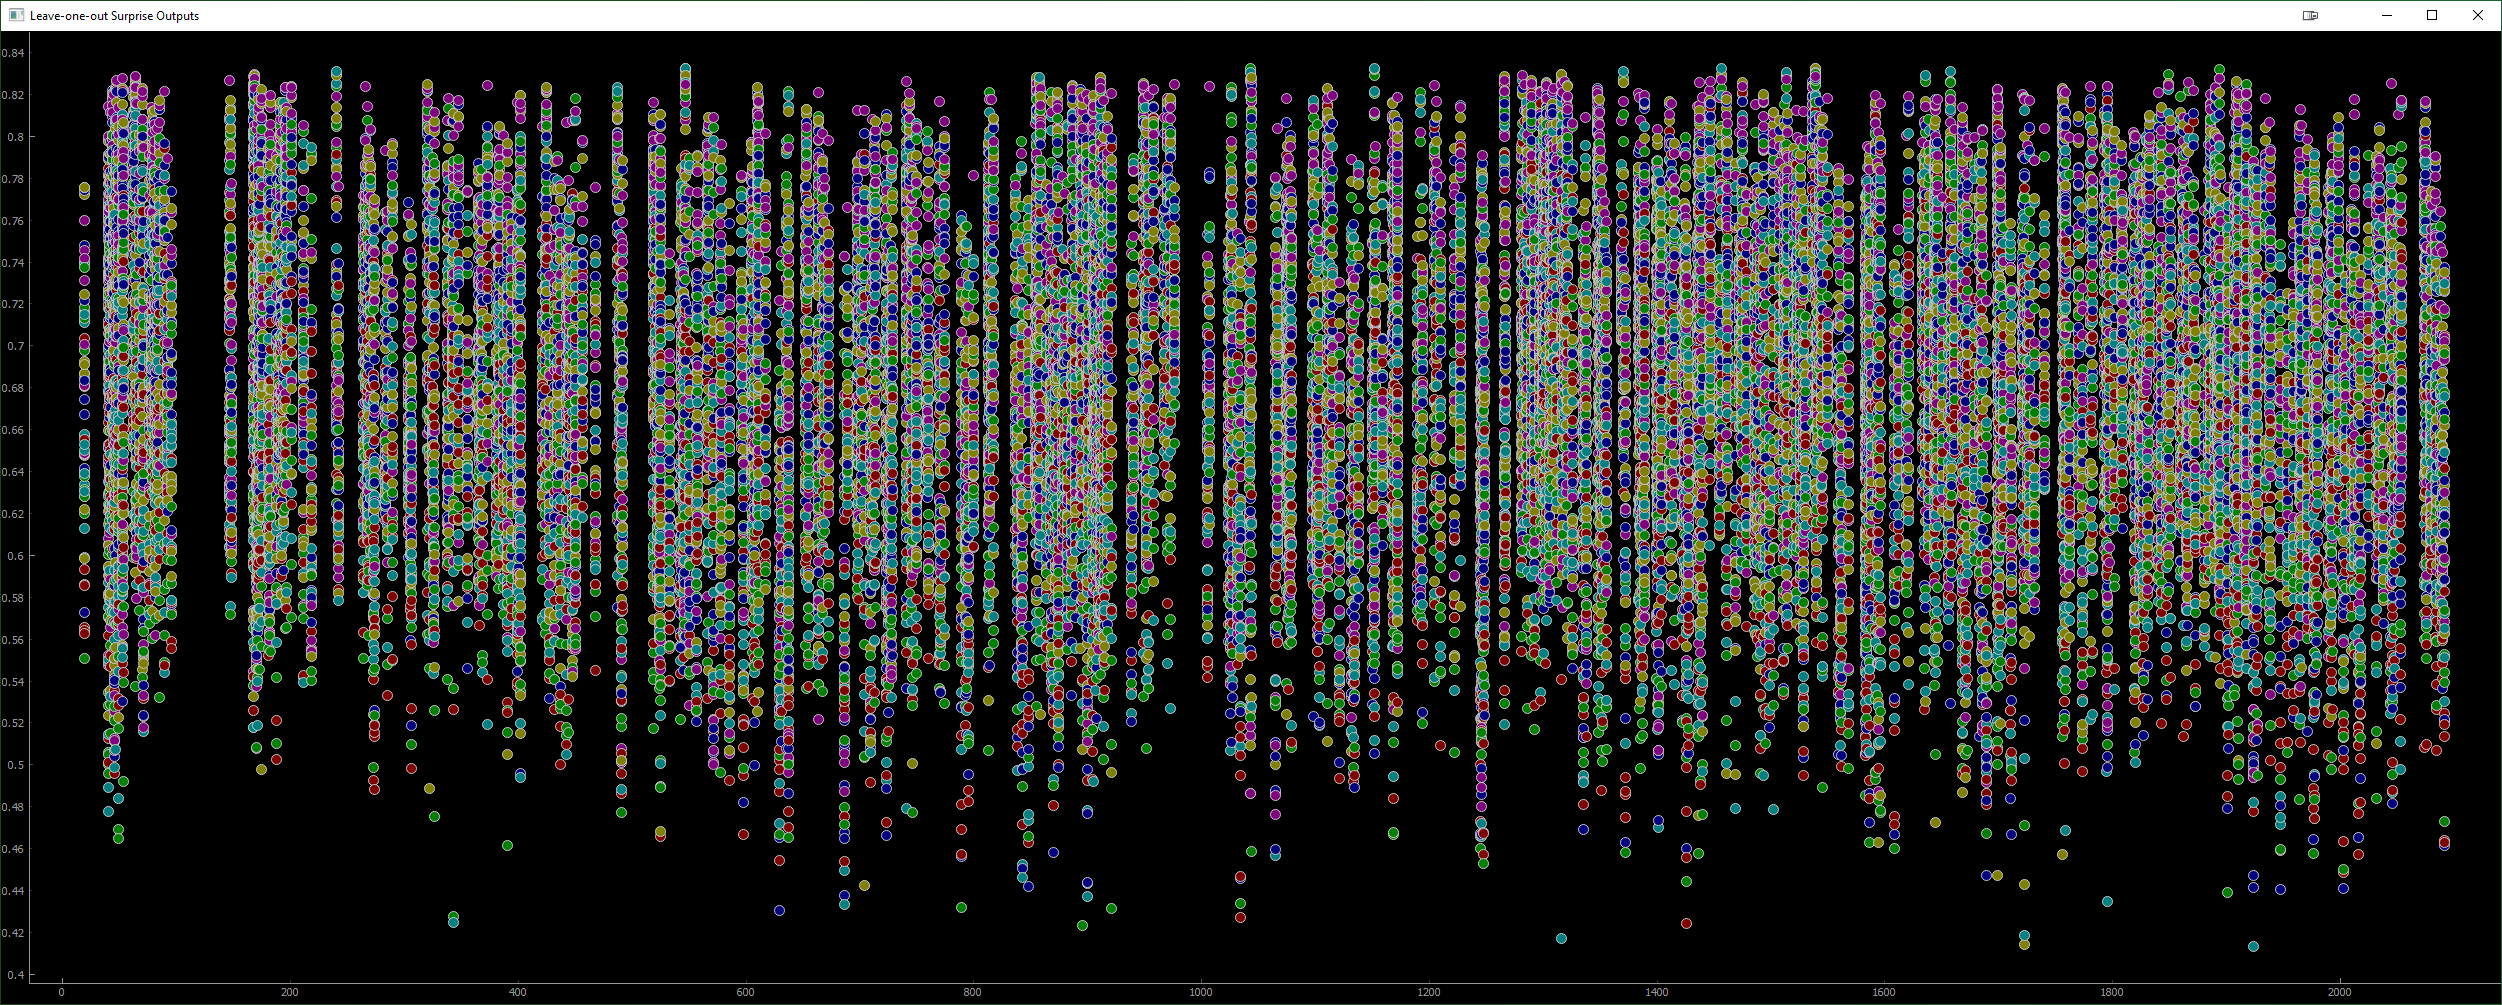{width=10%}

In [ ]:
import pyphoplacecellanalysis.External.pyqtgraph as pg
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot

In [ ]:

num_cells = original_1D_decoder.num_neurons
num_epochs = active_filter_epochs.n_epochs

# make a separate symbol_brush color for each cell:
cell_color_symbol_brush = [pg.intColor(i,hues=9, values=3, alpha=180) for i, aclu in enumerate(original_1D_decoder.neuron_IDs)] # maxValue=128

In [ ]:
## Mean Surprises for each cell and each Epoch
win = pg.plot()
win.setWindowTitle('Leave-one-out Mean Surprise Outputs')

## add scatter plots on top
for decoded_epoch_idx in np.arange(active_filter_epochs.n_epochs): # [0:5]
    # Use mean time_bin and surprise for each epoch
    curr_epoch_time_bins = all_epochs_decoded_epoch_time_bins_mean[decoded_epoch_idx]
    curr_epoch_surprises = all_epochs_computed_cell_surprises_mean[decoded_epoch_idx]
    win.plot(x=curr_epoch_time_bins, y=curr_epoch_surprises, pen=None, symbol='o', symbolBrush=cell_color_symbol_brush) #  symbolBrush=pg.intColor(i,6,maxValue=128)
    
win.graphicsItem().setLabel(axis='left', text='Leave-one-out Mean Surprise')
win.graphicsItem().setLabel(axis='bottom', text='time')

In [ ]:
## Expected vs. Observed Firing Rates for each cell and each epoch:
win = pg.plot()
# win.setWindowTitle('Leave-one-out Expected vs. Observed Firing Rates')
win.setWindowTitle('Leave-one-out Expected vs. Observed Num Spikes')
plots = {}

# legend_size = (80,60) # fixed size legend
legend_size = None # auto-sizing legend to contents
legend = pg.LegendItem(legend_size, offset=(-1,0)) # do this instead of # .addLegend
legend.setParentItem(win.graphicsItem())

## add scatter plots on top
for i, aclu in enumerate(original_1D_decoder.neuron_IDs):
    unit_IDX = original_1D_decoder.neuron_IDXs[i] # should just be i, but just to be safe
    # find only the time bins when the cell fires:
    curr_epoch_is_cell_active = is_cell_firing_time_bin[unit_IDX, :]
    # Use mean time_bin and surprise for each epoch
    curr_epoch_time_bins = flat_all_epochs_decoded_epoch_time_bins[unit_IDX, curr_epoch_is_cell_active]
    curr_epoch_data = flat_all_epochs_measured_cell_firing_rates[unit_IDX, curr_epoch_is_cell_active] # num measured spikes 
    # curr_epoch_data = flat_all_epochs_measured_cell_spike_counts[unit_IDX, curr_epoch_is_cell_active] # num measured spikes 
    # curr_epoch_data = flat_all_epochs_difference_from_expected_cell_spike_counts[unit_IDX, curr_epoch_is_cell_active] # num spikes diff
    # curr_epoch_data = flat_all_epochs_difference_from_expected_cell_firing_rates[unit_IDX, :] # firing rate diff
    plots[aclu] = win.plot(x=curr_epoch_time_bins, y=curr_epoch_data, pen=None, symbol='o', symbolBrush=cell_color_symbol_brush[unit_IDX], name=f'{aclu}') #  symbolBrush=pg.intColor(i,6,maxValue=128)
    legend.addItem(plots[aclu], f'{aclu}')
    
win.graphicsItem().setLabel(axis='left', text='Expected vs. Observed # Spikes')
win.graphicsItem().setLabel(axis='bottom', text='time')

In [ ]:
long_results_obj.

In [ ]:
win.close()

In [ ]:
flat_all_epochs_difference_from_expected_cell_firing_rates.shape

In [ ]:
def plot_long_short_expected_vs_observed_firing_rates(long_results_obj, short_results_obj, limit_aclus=None):
    """ 2023-03-28 4:30pm - Expected vs. Observed Firing Rates for each cell and each epoch 
    
    """
    num_cells = long_results_obj.original_1D_decoder.num_neurons
    num_epochs = long_results_obj.active_filter_epochs.n_epochs
    # make a separate symbol_brush color for each cell:
    cell_color_symbol_brush = [pg.intColor(i,hues=9, values=3, alpha=180) for i, aclu in enumerate(long_results_obj.original_1D_decoder.neuron_IDs)] # maxValue=128
    # All properties in common:
    win = pg.plot()
     # win.setWindowTitle('Short v. Long - Leave-one-out Expected vs. Observed Firing Rates')
    win.setWindowTitle('Short v. Long - Leave-one-out Expected vs. Observed Num Spikes')
    # legend_size = (80,60) # fixed size legend
    legend_size = None # auto-sizing legend to contents
    legend = pg.LegendItem(legend_size, offset=(-1,0)) # do this instead of # .addLegend
    legend.setParentItem(win.graphicsItem())
    # restrict the aclus to display to limit_aclus
    if limit_aclus is None:
        limit_aclus = long_results_obj.original_1D_decoder.neuron_IDs
    # check whether the neuron_ID is included:
    is_neuron_ID_active = np.isin(long_results_obj.original_1D_decoder.neuron_IDs, limit_aclus)    
    # restrict to the limit indicies
    active_neuron_IDs = np.array(long_results_obj.original_1D_decoder.neuron_IDs)[is_neuron_ID_active]
    active_neuron_IDXs =  np.array(long_results_obj.original_1D_decoder.neuron_IDXs)[is_neuron_ID_active]

    plots_tuple = tuple([{}, {}])
    label_prefix_list = ['long', 'short']
    long_short_symbol_list = ['t', 't1'] # note: 's' is a square. 'o', 't1': triangle pointing upwards
    
    for long_or_short_idx, a_results_obj in enumerate((long_results_obj, short_results_obj)):
        label_prefix = label_prefix_list[long_or_short_idx]
        # print(F'long_or_short_idx: {long_or_short_idx = }, label_prefix: {label_prefix =}')
        plots = plots_tuple[long_or_short_idx]
        curr_symbol = long_short_symbol_list[long_or_short_idx]
        
        ## add scatter plots on top
        for unit_IDX, aclu in zip(active_neuron_IDXs, active_neuron_IDs):
            # find only the time bins when the cell fires:
            curr_epoch_is_cell_active = np.logical_not(a_results_obj.is_non_firing_time_bin)[unit_IDX, :]
            # Use mean time_bin and surprise for each epoch
            curr_epoch_time_bins = a_results_obj.flat_all_epochs_decoded_epoch_time_bins[unit_IDX, curr_epoch_is_cell_active]
            # curr_epoch_data = a_results_obj.flat_all_epochs_measured_cell_firing_rates[unit_IDX, curr_epoch_is_cell_active] # measured firing rates (Hz) 
            # curr_epoch_data = a_results_obj.flat_all_epochs_measured_cell_spike_counts[unit_IDX, curr_epoch_is_cell_active] # num measured spikes 
            curr_epoch_data = a_results_obj.flat_all_epochs_difference_from_expected_cell_spike_counts[unit_IDX, curr_epoch_is_cell_active] # num spikes diff
            # curr_epoch_data = a_results_obj.flat_all_epochs_difference_from_expected_cell_firing_rates[unit_IDX, :] # firing rate diff
            plots[aclu] = win.plot(x=curr_epoch_time_bins, y=curr_epoch_data, pen=None, symbol=curr_symbol, symbolBrush=cell_color_symbol_brush[unit_IDX], name=f'{label_prefix}[{aclu}]', alpha=0.5) #  symbolBrush=pg.intColor(i,6,maxValue=128)
            legend.addItem(plots[aclu], f'{label_prefix}[{aclu}]')

    win.graphicsItem().setLabel(axis='left', text='Short v. Long - Expected vs. Observed # Spikes')
    win.graphicsItem().setLabel(axis='bottom', text='time')
    return win, plots_tuple, legend

win, plots_tuple, legend = plot_long_short_expected_vs_observed_firing_rates(long_results_obj, short_results_obj, limit_aclus=[20])

In [ ]:


def plot_long_short_any_values(long_results_obj, short_results_obj, x, y, limit_aclus=None):
    """ 2023-03-28 4:31pm - Any values, specified by a lambda function for each cell and each epoch 
    """
    num_cells = long_results_obj.original_1D_decoder.num_neurons
    num_epochs = long_results_obj.active_filter_epochs.n_epochs
    # make a separate symbol_brush color for each cell:
    cell_color_symbol_brush = [pg.intColor(i,hues=9, values=3, alpha=180) for i, aclu in enumerate(long_results_obj.original_1D_decoder.neuron_IDs)] # maxValue=128
    # All properties in common:
    win = pg.plot()
    win.setWindowTitle('Short v. Long - Leave-one-out Custom Surprise Plot')
    # legend_size = (80,60) # fixed size legend
    legend_size = None # auto-sizing legend to contents
    legend = pg.LegendItem(legend_size, offset=(-1,0)) # do this instead of # .addLegend
    legend.setParentItem(win.graphicsItem())
    # restrict the aclus to display to limit_aclus
    if limit_aclus is None:
        limit_aclus = long_results_obj.original_1D_decoder.neuron_IDs
    # check whether the neuron_ID is included:
    is_neuron_ID_active = np.isin(long_results_obj.original_1D_decoder.neuron_IDs, limit_aclus)    
    # restrict to the limit indicies
    active_neuron_IDs = np.array(long_results_obj.original_1D_decoder.neuron_IDs)[is_neuron_ID_active]
    active_neuron_IDXs =  np.array(long_results_obj.original_1D_decoder.neuron_IDXs)[is_neuron_ID_active]

    plots_tuple = tuple([{}, {}])
    label_prefix_list = ['long', 'short']
    long_short_symbol_list = ['t', 'o'] # note: 's' is a square. 'o', 't1': triangle pointing upwards
    
    for long_or_short_idx, a_results_obj in enumerate((long_results_obj, short_results_obj)):
        label_prefix = label_prefix_list[long_or_short_idx]
        # print(F'long_or_short_idx: {long_or_short_idx = }, label_prefix: {label_prefix =}')
        plots = plots_tuple[long_or_short_idx]
        curr_symbol = long_short_symbol_list[long_or_short_idx]
        
        ## add scatter plots on top
        for unit_IDX, aclu in zip(active_neuron_IDXs, active_neuron_IDs):
            # find only the time bins when the cell fires:
            curr_epoch_is_cell_active = np.logical_not(a_results_obj.is_non_firing_time_bin)[unit_IDX, :]
            # Use mean time_bin and surprise for each epoch
            curr_epoch_time_bins = a_results_obj.flat_all_epochs_decoded_epoch_time_bins[unit_IDX, curr_epoch_is_cell_active]
            # curr_epoch_data = a_results_obj.flat_all_epochs_measured_cell_firing_rates[unit_IDX, curr_epoch_is_cell_active] # measured firing rates (Hz) 
            # curr_epoch_data = a_results_obj.flat_all_epochs_measured_cell_spike_counts[unit_IDX, curr_epoch_is_cell_active] # num measured spikes 
            # curr_epoch_data = a_results_obj.flat_all_epochs_difference_from_expected_cell_spike_counts[unit_IDX, curr_epoch_is_cell_active] # num spikes diff
            # curr_epoch_data = a_results_obj.flat_all_epochs_difference_from_expected_cell_firing_rates[unit_IDX, :] # firing rate diff
            print(f'curr_epoch_time_bins.shape: {np.shape(curr_epoch_time_bins)}')
            curr_epoch_data = y(a_results_obj) # [unit_IDX, curr_epoch_is_cell_active]
            print(f'np.shape(curr_epoch_data): {np.shape(curr_epoch_data)}')
            curr_epoch_data = curr_epoch_data[unit_IDX, curr_epoch_is_cell_active]
            plots[aclu] = win.plot(x=curr_epoch_time_bins, y=curr_epoch_data, pen=None, symbol=curr_symbol, symbolBrush=cell_color_symbol_brush[unit_IDX], name=f'{label_prefix}[{aclu}]', alpha=0.5) #  symbolBrush=pg.intColor(i,6,maxValue=128)
            legend.addItem(plots[aclu], f'{label_prefix}[{aclu}]')

    win.graphicsItem().setLabel(axis='left', text='Short v. Long - Surprise (Custom)')
    win.graphicsItem().setLabel(axis='bottom', text='time')
    return win, plots_tuple, legend

x_fn = lambda a_results_obj: a_results_obj.all_epochs_decoded_epoch_time_bins_mean[:,0]
# y_fn = lambda a_results_obj: a_results_obj.all_epochs_all_cells_one_left_out_posterior_to_scrambled_pf_surprises_mean
# y_fn = lambda a_results_obj: a_results_obj.all_epochs_all_cells_one_left_out_posterior_to_pf_surprises_mean
y_fn = lambda a_results_obj: a_results_obj.all_epochs_computed_one_left_out_posterior_to_pf_surprises

# (time_bins, neurons), (epochs, neurons), (epochs)
# all_epochs_computed_one_left_out_posterior_to_pf_surprises, all_epochs_computed_cell_one_left_out_posterior_to_pf_surprises_mean, all_epochs_all_cells_one_left_out_posterior_to_pf_surprises_mean
win, plots_tuple, legend = plot_long_short_any_values(long_results_obj, short_results_obj, x=x_fn, y=y_fn, limit_aclus=[20])

In [ ]:
import pyphoplacecellanalysis.External.pyqtgraph as pg
win = pg.plot()
win.setWindowTitle('Short v. Long - Leave-one-out All Cell Average Surprise Outputs')
# legend_size = (80,60) # fixed size legend
legend_size = None # auto-sizing legend to contents
legend = pg.LegendItem(legend_size, offset=(-1,0)) # do this instead of # .addLegend
legend.setParentItem(win.graphicsItem())

ax_long = win.plot(x=long_results_obj.all_epochs_decoded_epoch_time_bins_mean[:,0], y=long_results_obj.all_epochs_all_cells_one_left_out_posterior_to_pf_surprises_mean, pen=None, symbol='o', symbolBrush=pg.intColor(0,6,maxValue=128), name=f'long') #  symbolBrush=pg.intColor(i,6,maxValue=128)
legend.addItem(ax_long, f'long')
ax_short = win.plot(x=short_results_obj.all_epochs_decoded_epoch_time_bins_mean[:,0], y=short_results_obj.all_epochs_all_cells_one_left_out_posterior_to_pf_surprises_mean, pen=None, symbol='o', symbolBrush=pg.intColor(1,6,maxValue=128), name=f'short') #  symbolBrush=pg.intColor(i,6,maxValue=128)
legend.addItem(ax_short, f'short')

win.graphicsItem().setLabel(axis='left', text='Short v. Long - Leave-one-out All Cell Average Surprise')
win.graphicsItem().setLabel(axis='bottom', text='time')

Surprised averaged over all cells at each Epoch:
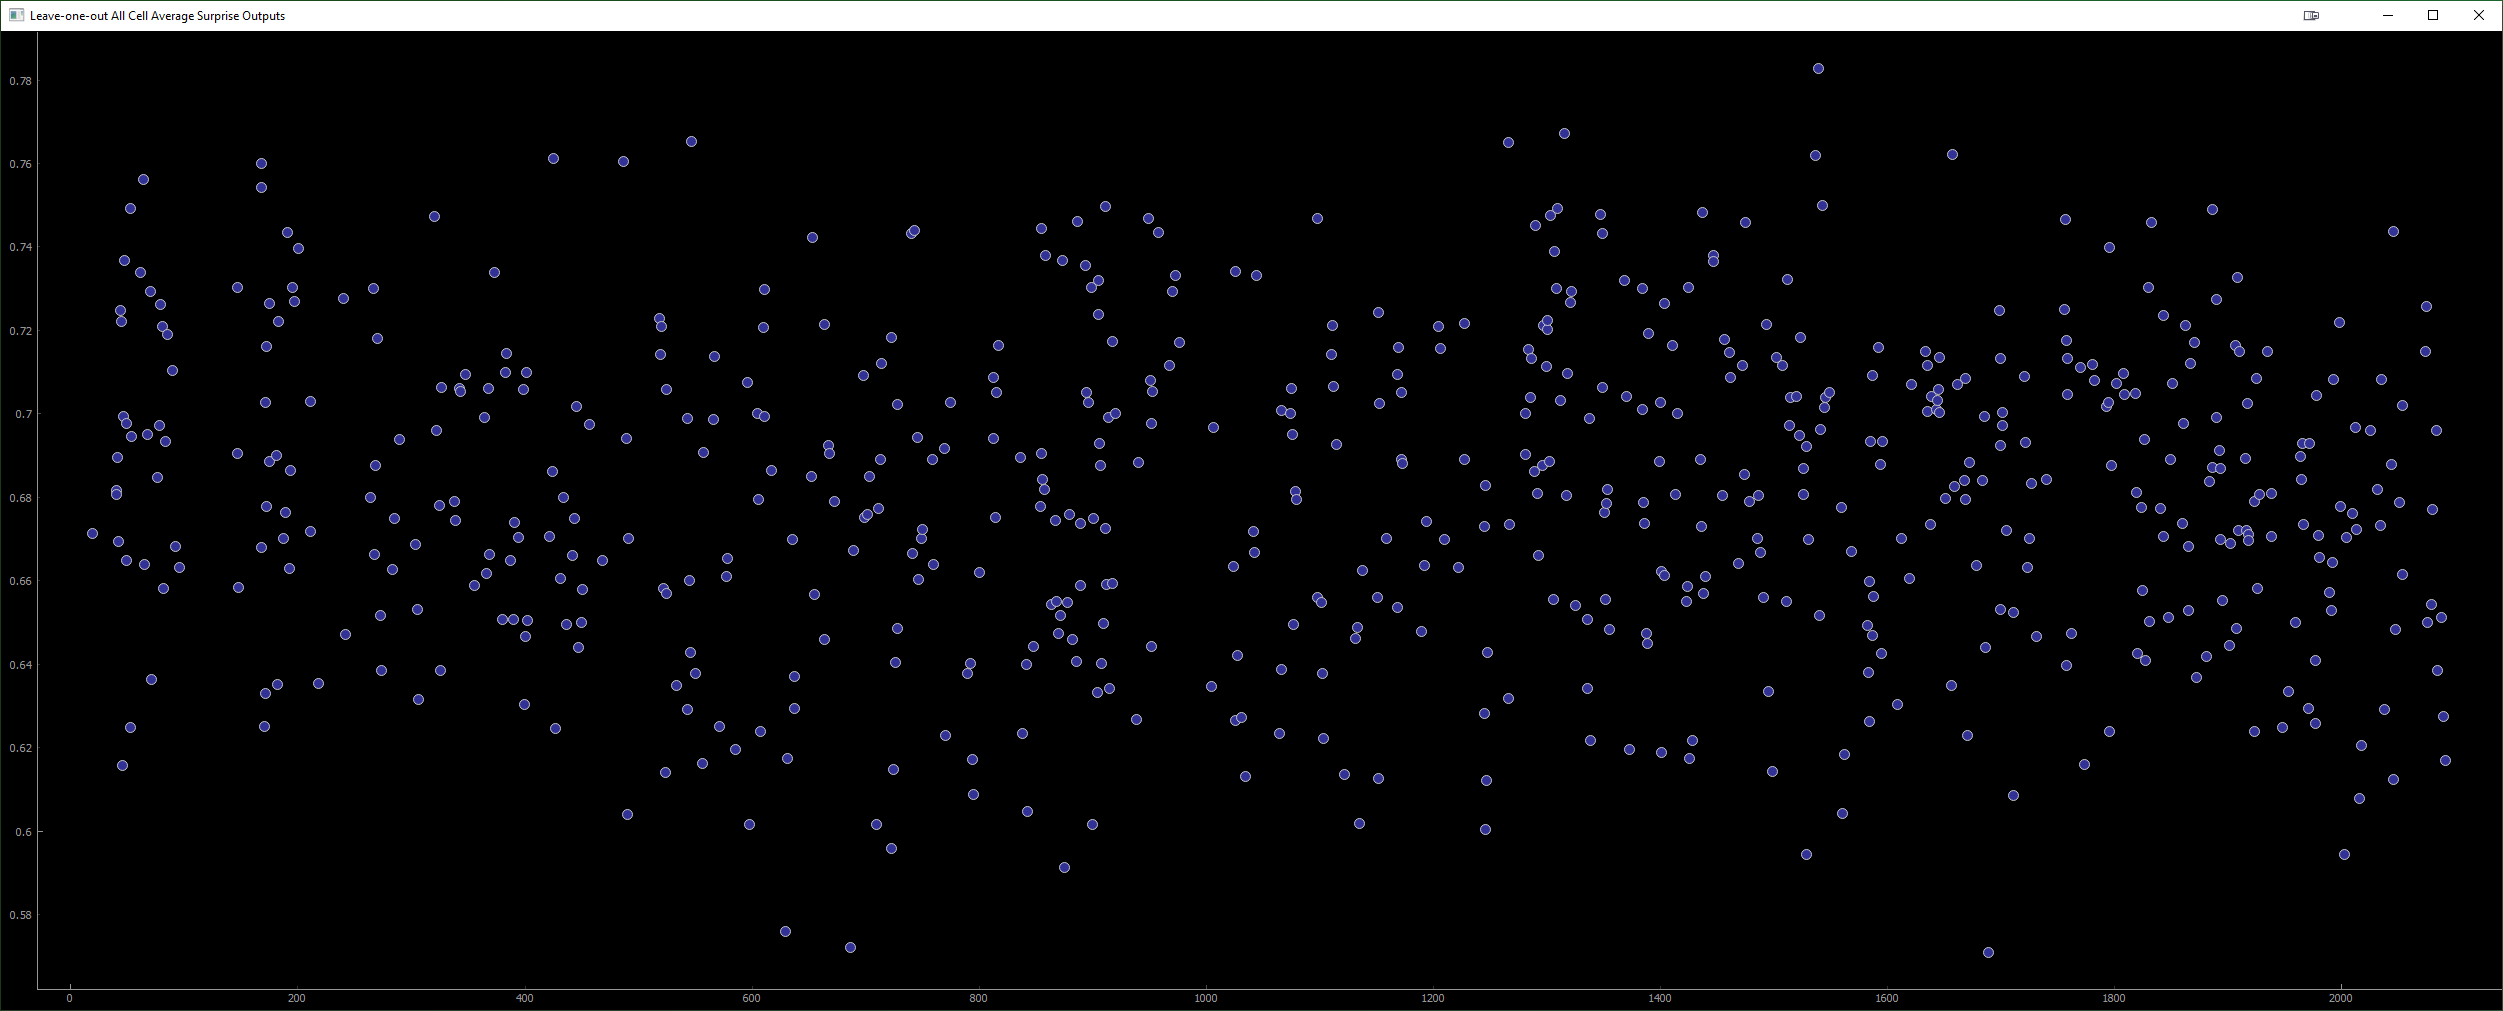

In [ ]:
import pyphoplacecellanalysis.External.pyqtgraph as pg
win = pg.plot()
win.setWindowTitle('Leave-one-out All Cell Average Surprise Outputs')
epoch_time_centers = all_epochs_decoded_epoch_time_bins_mean[:,0]
win.plot(x=epoch_time_centers, y=all_epochs_all_cells_computed_surprises_mean, pen=None, symbol='o')
win.graphicsItem().setLabel(axis='left', text='Leave-one-out All Cell Average Surprise')
win.graphicsItem().setLabel(axis='bottom', text='time')
# # Make error bars
# plt_errorbar = pg.ErrorBarItem(x=epoch_time_centers, y=all_epochs_all_cells_computed_surprises_mean, height=np.std(all_epochs_computed_cell_surprises_mean, axis=1), beam=0.5, pen={'color':'w', 'width':2})
# win.addItem(plt_errorbar)

# 2023-03-16 - Plot long/short versions:

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.DefaultComputationFunctions import LeaveOneOutDecodingResult

In [ ]:
import pyphoplacecellanalysis.External.pyqtgraph as pg
win = pg.plot()
win.setWindowTitle('Short v. Long - Leave-one-out All Cell Average Surprise Outputs')
# legend_size = (80,60) # fixed size legend
legend_size = None # auto-sizing legend to contents
legend = pg.LegendItem(legend_size, offset=(-1,0)) # do this instead of # .addLegend
legend.setParentItem(win.graphicsItem())

ax_long = win.plot(x=long_results_obj.all_epochs_decoded_epoch_time_bins_mean[:,0], y=long_results_obj.all_epochs_all_cells_computed_surprises_mean, pen=None, symbol='o', symbolBrush=pg.intColor(0,6,maxValue=128), name=f'long') #  symbolBrush=pg.intColor(i,6,maxValue=128)
legend.addItem(ax_long, f'long')
ax_short = win.plot(x=short_results_obj.all_epochs_decoded_epoch_time_bins_mean[:,0], y=short_results_obj.all_epochs_all_cells_computed_surprises_mean, pen=None, symbol='o', symbolBrush=pg.intColor(1,6,maxValue=128), name=f'short') #  symbolBrush=pg.intColor(i,6,maxValue=128)
legend.addItem(ax_short, f'short')

win.graphicsItem().setLabel(axis='left', text='Short v. Long - Leave-one-out All Cell Average Surprise')
win.graphicsItem().setLabel(axis='bottom', text='time')

In [ ]:
import pyphoplacecellanalysis.External.pyqtgraph as pg

def plot_long_short(long_results_obj, short_results_obj):
    win = pg.plot()
    win.setWindowTitle('Short v. Long - Leave-one-out All Cell Average Surprise Outputs')
    # legend_size = (80,60) # fixed size legend
    legend_size = None # auto-sizing legend to contents
    legend = pg.LegendItem(legend_size, offset=(-1,0)) # do this instead of # .addLegend
    legend.setParentItem(win.graphicsItem())

    ax_long = win.plot(x=long_results_obj.all_epochs_decoded_epoch_time_bins_mean[:,0], y=long_results_obj.all_epochs_all_cells_computed_surprises_mean, pen=None, symbol='o', symbolBrush=pg.intColor(0,6,maxValue=128), name=f'long') #  symbolBrush=pg.intColor(i,6,maxValue=128)
    legend.addItem(ax_long, f'long')
    ax_short = win.plot(x=short_results_obj.all_epochs_decoded_epoch_time_bins_mean[:,0], y=short_results_obj.all_epochs_all_cells_computed_surprises_mean, pen=None, symbol='o', symbolBrush=pg.intColor(1,6,maxValue=128), name=f'short') #  symbolBrush=pg.intColor(i,6,maxValue=128)
    legend.addItem(ax_short, f'short')

    win.graphicsItem().setLabel(axis='left', text='Short v. Long - Leave-one-out All Cell Average Surprise')
    win.graphicsItem().setLabel(axis='bottom', text='time')
    return win, (ax_long, ax_short), legend

# 2023-03-24 - NEWN#ERIWEHROIEWRBNsznbhipozsfd'r

In [ ]:
import pyphoplacecellanalysis.External.pyqtgraph as pg
win = pg.plot()
win.setWindowTitle('Short v. Long - Leave-one-out All Cell Average Surprise Outputs')
# legend_size = (80,60) # fixed size legend
legend_size = None # auto-sizing legend to contents
legend = pg.LegendItem(legend_size, offset=(-1,0)) # do this instead of # .addLegend
legend.setParentItem(win.graphicsItem())

ax_long = win.plot(x=long_results_obj.all_epochs_decoded_epoch_time_bins_mean[:,0], y=long_results_obj.all_epochs_all_cells_one_left_out_posterior_to_pf_surprises_mean, pen=None, symbol='o', symbolBrush=pg.intColor(0,6,maxValue=128), name=f'long') #  symbolBrush=pg.intColor(i,6,maxValue=128)
legend.addItem(ax_long, f'long')
ax_short = win.plot(x=short_results_obj.all_epochs_decoded_epoch_time_bins_mean[:,0], y=short_results_obj.all_epochs_all_cells_one_left_out_posterior_to_pf_surprises_mean, pen=None, symbol='o', symbolBrush=pg.intColor(1,6,maxValue=128), name=f'short') #  symbolBrush=pg.intColor(i,6,maxValue=128)
legend.addItem(ax_short, f'short')

win.graphicsItem().setLabel(axis='left', text='Short v. Long - Leave-one-out All Cell Average Surprise')
win.graphicsItem().setLabel(axis='bottom', text='time')

In [ ]:
import pyphoplacecellanalysis.External.pyqtgraph as pg
win = pg.plot()
win.setWindowTitle('Long v. Scrambled Long - Leave-one-out All Cell Average Surprise Outputs')
# legend_size = (80,60) # fixed size legend
legend_size = None # auto-sizing legend to contents
legend = pg.LegendItem(legend_size, offset=(-1,0)) # do this instead of # .addLegend
legend.setParentItem(win.graphicsItem())

ax_long = win.plot(x=long_results_obj.all_epochs_decoded_epoch_time_bins_mean[:,0], y=long_results_obj.all_epochs_all_cells_one_left_out_posterior_to_pf_surprises_mean, pen=None, symbol='o', symbolBrush=pg.intColor(0,6,maxValue=128), name=f'long') #  symbolBrush=pg.intColor(i,6,maxValue=128)
legend.addItem(ax_long, f'long')
ax_short = win.plot(x=short_results_obj.all_epochs_decoded_epoch_time_bins_mean[:,0], y=long_results_obj.all_epochs_all_cells_one_left_out_posterior_to_scrambled_pf_surprises_mean, pen=None, symbol='o', symbolBrush=pg.intColor(1,6,maxValue=128), name=f'scrambled long') #  symbolBrush=pg.intColor(i,6,maxValue=128)
legend.addItem(ax_short, f'scrambled long')
win.graphicsItem().setLabel(axis='left', text='Long v. Scrambled Long - Leave-one-out All Cell Average Surprise')
win.graphicsItem().setLabel(axis='bottom', text='time')

In [ ]:
win.show()

In [ ]:
curr_plotting_config = curr_active_pipeline.active_configs[global_epoch_name].plotting_config

In [ ]:
fig_out_path = curr_plotting_config.get_figure_save_path('leave-one-out-all-cell-avg-surprise-outputs').with_suffix('.png')
fig_out_path

In [ ]:
export_pyqtgraph_plot(win.scene(), savepath=fig_out_path)

In [ ]:
np.all(long_results_dict['all_epochs_decoded_epoch_time_bins_mean'] == short_results_dict['all_epochs_decoded_epoch_time_bins_mean'])

In [ ]:
long_results_dict['all_epochs_decoded_epoch_time_bins_mean'].shape # (614, 104)

In [ ]:
short_results_dict['all_epochs_decoded_epoch_time_bins_mean'].shape # (614, 100)

In [ ]:
long_results_dict['all_epochs_decoded_epoch_time_bins_mean'][:,0]

In [ ]:
short_results_dict['all_epochs_decoded_epoch_time_bins_mean']

In [ ]:
np.isclose(long_results_dict['all_epochs_decoded_epoch_time_bins_mean'], short_results_dict['all_epochs_decoded_epoch_time_bins_mean']) # shapes (614,104) (614,100)

In [ ]:
long_results_dict['all_epochs_all_cells_computed_surprises_mean'] == short_results_dict['all_epochs_all_cells_computed_surprises_mean']

In [ ]:
np.allclose(long_results_dict['all_epochs_all_cells_computed_surprises_mean'], short_results_dict['all_epochs_all_cells_computed_surprises_mean'], equal_nan=True)

In [ ]:
short_results_dict['all_epochs_all_cells_computed_surprises_mean'] # .shape # (614,)

In [ ]:
long_results_dict['all_epochs_all_cells_computed_surprises_mean'] # .shape # (614,)

# 2023-03-22 - Surprise Concept Validation - Checking my understanding of surpise on clear example posteriors

In [ ]:
from scipy.spatial import distance # for Jensen-Shannon distance in `_subfn_compute_leave_one_out_analysis`
from scipy.stats import wasserstein_distance

In [ ]:
## Get two posteriors for the long and short
example_left_out_neuron_IDX = 9
example_aclu = long_shared_aclus_only_decoder.neuron_IDs[example_left_out_neuron_IDX]
print(f'{example_left_out_neuron_IDX = }, {example_aclu = }')

# def _get_decoder_pf(original_1D_decoder, i, left_out_aclu):
#     left_out_neuron_IDX = original_1D_decoder.neuron_IDXs[i] # should just be i, but just to be safe
#     curr_cell_tuning_curve = original_1D_decoder.pf.ratemap.tuning_curves[left_out_neuron_IDX]
#     # curr_cell_spike_curve = original_1D_decoder.pf.ratemap.spikes_maps[unit_IDX] ## not occupancy weighted... is this the right one to use for computing the expected spike rate? NO... doesn't seem like it

#     left_out_decoder_result = one_left_out_filter_epochs_decoder_result_dict[left_out_aclu]

In [ ]:
example_aclu = 98 # from specified ACLU
example_left_out_neuron_IDX = list(long_shared_aclus_only_decoder.pf.included_neuron_IDs).index(example_aclu)
assert example_left_out_neuron_IDX > -1
assert long_shared_aclus_only_decoder.pf.included_neuron_IDs[example_left_out_neuron_IDX] == example_aclu
print(f'{example_left_out_neuron_IDX = }, {example_aclu = }')

In [ ]:
long_example_pf, short_example_pf = [a_decoder.pf.ratemap.tuning_curves[example_left_out_neuron_IDX] for a_decoder in (long_shared_aclus_only_decoder, short_shared_aclus_only_decoder)]
fig, ax, im = visualize_heatmap(long_example_pf, title=f"long_example_pf: {example_aclu}")
fig, ax, im = visualize_heatmap(short_example_pf, title=f"short_example_pf: {example_aclu}")
distance.jensenshannon(long_example_pf, short_example_pf)
wasserstein_distance(long_example_pf, short_example_pf)
wasserstein_distance(long_example_pf, short_example_pf)

In [ ]:
%pdb off

In [ ]:
short_non_matching_example_pf.

In [ ]:
# get a placefield for a completely different aclu (that should match less than the correct one):
## TODO: 2023-03-22 - Why are `example_incongurent_neuron_IDX` = [3, 4] and potentially others the same as 0??
example_incongurent_neuron_IDX = 5
short_non_matching_example_pf = short_shared_aclus_only_decoder.pf.ratemap.tuning_curves[example_incongurent_neuron_IDX]
fig, ax, im = visualize_heatmap(short_non_matching_example_pf, title=f"short_non_matching_example_pf: {short_shared_aclus_only_decoder.neuron_IDs[example_incongurent_neuron_IDX]}")

In [ ]:
## Plot rolled placefield
def _scramble_curve(pf: np.ndarray, method='circ'):
    """ Circularly rotates the 1D placefield """
    roll_num_bins = 10
    return np.roll(pf, roll_num_bins)

scrambled_pf = _scramble_curve(short_non_matching_example_pf)
fig, ax, im = visualize_heatmap(scrambled_pf, title=f"scrambled_pf: {short_shared_aclus_only_decoder.neuron_IDs[example_incongurent_neuron_IDX]}")

In [ ]:
# Compares `a_target_curve` to all others present in the decoder and plots the 5 most and least distant to it:

a_decoder = long_shared_aclus_only_decoder
# # exclude self from comparison:
# all_aclus_except_target = shared_aclus[shared_aclus != example_aclu]
# all_neuron_IDXs_except_target = a_decoder.neuron_IDXs[np.isin(shared_aclus, [example_aclu], invert=True)]
# Include self curve:
all_aclus_except_target = shared_aclus.copy()
all_neuron_IDXs_except_target = a_decoder.neuron_IDXs.copy()
a_target_curve = a_decoder.pf.ratemap.tuning_curves[example_left_out_neuron_IDX] # the curve to match

In [ ]:
# sort_result_by_distance ='jensenshannon'
sort_result_by_distance ='wasserstein'

compare_curves = [a_decoder.pf.ratemap.tuning_curves[idx] for idx, aclu in zip(all_neuron_IDXs_except_target, all_aclus_except_target)]
# compute several different distance metrics to compare:
compare_distances_jensenshannon = [distance.jensenshannon(a_target_curve, a_curve) for a_curve in compare_curves]
compare_distances_wasserstein = [wasserstein_distance(a_target_curve, a_curve) for a_curve in compare_curves]

## Output dataframe:
compare_distance_df = pd.DataFrame({'compare_aclus': all_aclus_except_target, 'compare_neuron_IDXs':all_neuron_IDXs_except_target, 'jensenshannon': compare_distances_jensenshannon, 'wasserstein': compare_distances_wasserstein})

## Sort dataframe by jensenshannon distance:
compare_distance_df.sort_values(by=sort_result_by_distance, ascending=False, inplace=True) # this sort reveals the aclu values that when omitted had the largest performance decrease on decoding (as indicated by a larger distance)
most_distant_aclus = compare_distance_df.compare_aclus.values
most_distant_neuron_IDXs = compare_distance_df.compare_neuron_IDXs.values
compare_distance_df

In [ ]:
def _plot_nearest_matching_curves(a_target_curve, num_most_distant_to_display:int=10, num_least_distant_to_display:int=10):
    """ Plots the `num_most_distant_to_display` most distant and `num_least_distant_to_display` least distant curves to `a_target_curve` """
    fig, ax, im = visualize_heatmap(a_target_curve, title=f"a_target_curve: {example_aclu}")

	# get least matching curves:
    example_incongurent_neuron_IDX = most_distant_neuron_IDXs[:num_most_distant_to_display] # get first 5 most distant curves
    short_non_matching_example_pf = short_shared_aclus_only_decoder.pf.ratemap.tuning_curves[example_incongurent_neuron_IDX]
    fig1, ax1, im1 = visualize_heatmap(short_non_matching_example_pf, title=f"least matching curves (most distant): {np.array(short_shared_aclus_only_decoder.neuron_IDs)[example_incongurent_neuron_IDX]}")
    ax1.set_xlim(ax.get_xlim())
	# get most matching curves:
    example_incongurent_neuron_IDX = most_distant_neuron_IDXs[-num_least_distant_to_display:] # get 5 most matching (closest) curves
    short_non_matching_example_pf = short_shared_aclus_only_decoder.pf.ratemap.tuning_curves[example_incongurent_neuron_IDX]
    fig2, ax2, im2 = visualize_heatmap(short_non_matching_example_pf, title=f"most matching curves (least distant): {np.array(short_shared_aclus_only_decoder.neuron_IDs)[example_incongurent_neuron_IDX]}")
    ax2.set_xlim(ax.get_xlim())

_plot_nearest_matching_curves()

In [ ]:
plot_helper = curr_active_pipeline.plot

In [ ]:
plot_helper._display_1d_placefields

In [ ]:
curr_active_pipeline.filtered_contexts[long_epoch_name]

In [18]:
_out = curr_active_pipeline.display('_display_1d_placefields', active_session_configuration_context=curr_active_pipeline.filtered_contexts[long_epoch_name])

In [ ]:
_out = curr_active_pipeline.display('_display_1d_placefields', active_session_configuration_context=curr_active_pipeline.filtered_contexts[short_epoch_name])

In [ ]:
distance.jensenshannon(long_example_pf, short_non_matching_example_pf)

In [ ]:
wasserstein_distance(long_example_pf, short_non_matching_example_pf)

In [ ]:
example_incongurent_neuron_IDX = 29 # tight 14
short_non_matching_example_pf = short_shared_aclus_only_decoder.pf.ratemap.tuning_curves[example_incongurent_neuron_IDX]
fig, ax, im = visualize_heatmap(short_non_matching_example_pf, title=f"short_non_matching_example_pf: {short_shared_aclus_only_decoder.neuron_IDs[example_incongurent_neuron_IDX]}")

In [ ]:
distance.jensenshannon(long_example_pf, short_non_matching_example_pf)

In [ ]:
wasserstein_distance(long_example_pf, short_non_matching_example_pf)

In [ ]:
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'
out = curr_active_pipeline.display('_display_short_long_pf1D_comparison', active_identifying_session_ctx, single_figure=False, debug_print=False)


In [ ]:
short_shared_aclus_only_decoder.pf.plot_ratemaps_1D(sortby='id')

In [19]:
%matplotlib qt
_test_out = curr_active_pipeline.display('_display_placemaps_pyqtplot_2D', curr_active_pipeline.filtered_contexts[long_epoch_name])
_test_out

data_aspect_ratio: (3.677458732195299, Width_Height_Tuple(width=241.7178791533281, height=65.72959664703892))
nMapsToShow: 56, subplots: RowColTuple(num_rows=40, num_columns=3), max_subplots_per_page: 120
resolution_multiplier: 1.0, required_figure_size: (24.0, 19.0), required_figure_size_px: (2400.0, 1900.0)
final active_figure_size: (24.0, 19.0), required_figure_size_px: (2400.0, 1900.0) (after constraining by max_screen_figure_size, etc)
page_idx: 0


QGridLayoutEngine::addItem: Cell (0, 0) already taken


PyqtgraphRenderPlots({'name': 'PyqtgraphRenderPlots', 'app': None, 'parent_root_widget': <pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow.BasicBinnedImageRenderingWindow object at 0x7ff0eb67b430>, 'display_outputs': DynamicParameters({})})

Traceback (most recent call last):
  File "/home/halechr/repos/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/External/pyqtgraph/graphicsItems/AxisItem.py", line 636, in paint
    specs = self.generateDrawSpecs(painter)
  File "/home/halechr/repos/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/External/pyqtgraph/graphicsItems/AxisItem.py", line 1096, in generateDrawSpecs
    br = p.boundingRect(QtCore.QRectF(0, 0, 100, 100), QtCore.Qt.AlignmentFlag.AlignCenter, s)
TypeError: arguments did not match any overloaded call:
  boundingRect(self, rect: QRectF, flags: int, text: str): argument 3 has unexpected type 'numpy.float64'
  boundingRect(self, rect: QRect, flags: int, text: str): argument 1 has unexpected type 'QRectF'
  boundingRect(self, rectangle: QRectF, text: str, option: QTextOption = QTextOption()): argument 2 has unexpected type 'AlignmentFlag'
  boundingRect(self, x: int, y: int, w: int, h: int, flags: int, text: str): argument 1 has unexpected type 'QRectF'
Traceback (m

In [17]:
%matplotlib qt
_test_out = curr_active_pipeline.display('_display_1d_placefields', curr_active_pipeline.filtered_contexts[long_epoch_name])
_test_out

MatplotlibRenderPlots({'name': 'MatplotlibRenderPlots', 'figures': [<Figure size 550x1100 with 1 Axes>], 'axes': [(<Axes: title={'center': '1D Placemaps Placemaps (101 good cells)'}, xlabel='Position'>, array([ 67,  22,  53,   5,  30,   9,  31,  54,  29,  91,  99,  42,   7,
         1,  93,  46,  51,  50,  83,  73,  75,  58,  64,  80,  70,  52,
       100,  13,  47,  72,  76,  98,  23,  79,  41,  19,  69,  56,   6,
        61,  77,  62,  82,  84,  94,  97,  26,  88,  20,  33,  37,  35,
        36,  11,  27,  10,  63,  44,  14,  92,  90,  16,  34,   0,  18,
        25,   3,  21,  43,  71,   8,  66,  17,  49,  59,  60,  87,   2,
        86,  85,  38,  96,  45,  24,  40,  74,  32,  15,  95,   4,  55,
        65,  89,  68,  39,  57,  12,  28,  48,  81,  78], dtype=int64), array([[0.51764706, 0.55210084, 0.58655462, 0.6210084 , 0.65546218,
        0.68991597, 0.72436975, 0.75882353, 0.79327731, 0.82773109,
        0.86218487, 0.89663866, 0.93109244, 0.96554622, 1.        ,
        0.6980392

In [18]:
%matplotlib qt
_test_out = curr_active_pipeline.display('_display_normal', curr_active_pipeline.filtered_contexts[long_epoch_name])
_test_out

plot_all_placefields(...): active_epoch_placefields1D does not exist. Skipping it.


MatplotlibRenderPlots({'name': 'MatplotlibRenderPlots', 'figures': [<Figure size 640x480 with 2 Axes>, [<Figure size 5080x3947 with 209 Axes>]], 'axes': []})

c:\Users\pho\AppData\Local\pypoetry\Cache\virtualenvs\spike3d-WtdfU5rp-py3.9\lib\site-packages\ipykernel\eventloops.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  el.exec() if hasattr(el, 'exec') else el.exec_()


In [19]:
original_1D_decoder

original_1D_decoder.pf.plot_ratemaps_1D(sortby='id')

NameError: name 'original_1D_decoder' is not defined

In [ ]:
## for each cell:
for i, left_out_aclu in enumerate(original_1D_decoder.neuron_IDs):
	# aclu = original_1D_decoder.neuron_IDs[i]
	left_out_neuron_IDX = original_1D_decoder.neuron_IDXs[i] # should just be i, but just to be safe
	## TODO: only look at bins where the cell fires (is_cell_firing_time_bin[i])
	curr_cell_tuning_curve = original_1D_decoder.pf.ratemap.tuning_curves[left_out_neuron_IDX]
	# curr_cell_spike_curve = original_1D_decoder.pf.ratemap.spikes_maps[unit_IDX] ## not occupancy weighted... is this the right one to use for computing the expected spike rate? NO... doesn't seem like it

	left_out_decoder_result = one_left_out_filter_epochs_decoder_result_dict[left_out_aclu]
	## single cell outputs:
	curr_cell_decoded_epoch_time_bins = [] # will be a list of the time bins in each epoch that correspond to each surprise in the corresponding list in curr_cell_computed_epoch_surprises 
	curr_cell_computed_epoch_surprises = [] # will be a list of np.arrays, with each array representing the surprise of each time bin in each epoch
	all_cells_decoded_expected_firing_rates[left_out_aclu] = [] 
	all_cells_computed_epoch_one_left_out_to_global_surprises[left_out_aclu] = []


	# have one list of posteriors p_x_given_n for each decoded epoch (active_filter_epochs.n_epochs):
	assert len(left_out_decoder_result.p_x_given_n_list) == active_filter_epochs.n_epochs == left_out_decoder_result.num_filter_epochs

	## Compute the impact leaving each aclu out had on the average encoding performance:
	### 1. The distance between the actual measured position and the decoded position at each timepoint for each decoder. A larger magnitude difference implies a stronger, more positive effect on the decoding quality.
	one_left_out_omitted_aclu_distance[left_out_aclu] = [] # list to hold the distance results from the epochs
	## Iterate through each of the epochs for the given left_out_aclu (and its decoder), each of which has its own result

	for decoded_epoch_idx in np.arange(left_out_decoder_result.num_filter_epochs):
		curr_epoch_time_bin_container = left_out_decoder_result.time_bin_containers[decoded_epoch_idx]
		curr_time_bins = curr_epoch_time_bin_container.centers
		curr_epoch_p_x_given_n = left_out_decoder_result.p_x_given_n_list[decoded_epoch_idx] # .shape: (239, 5) - (n_x_bins, n_epoch_time_bins)
		assert curr_epoch_p_x_given_n.shape[0] == curr_cell_tuning_curve.shape[0]
		
		## Get the all-included values too for this decoded_epoch_idx:
		curr_epoch_all_included_p_x_given_n = all_included_filter_epochs_decoder_result.p_x_given_n_list[decoded_epoch_idx] # .shape: (239, 5) - (n_x_bins, n_epoch_time_bins)
		assert curr_epoch_p_x_given_n.shape[0] == curr_epoch_all_included_p_x_given_n.shape[0]

		## Need to exclude estimates from bins that didn't have any spikes in them (in general these glitch around):
		curr_total_spike_counts_per_window = np.sum(left_out_decoder_result.spkcount[decoded_epoch_idx], axis=0) # left_out_decoder_result.spkcount[i].shape # (69, 222) - (nCells, nTimeWindowCenters)
		curr_is_time_bin_non_firing = (curr_total_spike_counts_per_window == 0) # this would mean that no cells fired in this time bin
		# curr_non_firing_time_bin_indicies = np.where(curr_is_time_bin_non_firing)[0] # TODO: could also filter on a minimum number of spikes larger than zero (e.g. at least 2 spikes are required).
		curr_posterior_container = left_out_decoder_result.marginal_x_list[decoded_epoch_idx]
		curr_posterior = curr_posterior_container.p_x_given_n # TODO: check the posteriors too!
		curr_most_likely_positions = curr_posterior_container.most_likely_positions_1D

		## Compute the distance metric for this epoch:

		# Interpolate the measured positions to the window center times:
		window_center_measured_pos_x = np.interp(curr_time_bins, active_pos_df.t, active_pos_df.lin_pos)
		# ## PLOT_ONLY: NaN out the most_likely_positions that don't have spikes.
		# curr_most_likely_valid_positions = deepcopy(curr_most_likely_positions)
		# curr_most_likely_valid_positions[curr_non_firing_time_bin_indicies] = np.nan
		
		## Computed the distance metric finally:
		# is it fair to only compare the valid (windows containing at least one spike) windows?
		curr_omit_aclu_distance = distance.cdist(np.atleast_2d(window_center_measured_pos_x[~curr_is_time_bin_non_firing]), np.atleast_2d(curr_most_likely_positions[~curr_is_time_bin_non_firing]), 'sqeuclidean') # squared-euclidian distance between the two vectors
		# curr_omit_aclu_distance comes back double-wrapped in np.arrays for some reason (array([[659865.11994352]])), so .item() extracts the scalar value
		curr_omit_aclu_distance = curr_omit_aclu_distance.item()
		one_left_out_omitted_aclu_distance[left_out_aclu].append(curr_omit_aclu_distance)

		# Compute the expected firing rate for this cell during each bin by taking the computed position posterior and taking the sum of the element-wise product with the cell's placefield.
		# curr_epoch_expected_fr = np.array([np.sum(curr_cell_spike_curve * curr_p_x_given_n) for curr_p_x_given_n in curr_epoch_p_x_given_n.T]) / original_1D_decoder.time_bin_size
		curr_epoch_expected_fr = original_1D_decoder.pf.ratemap.tuning_curve_unsmoothed_peak_firing_rates[left_out_neuron_IDX] * np.array([np.sum(curr_cell_tuning_curve * curr_p_x_given_n) for curr_p_x_given_n in curr_epoch_p_x_given_n.T]) # * original_1D_decoder.pf.ratemap.
		all_cells_decoded_expected_firing_rates[left_out_aclu].append(curr_epoch_expected_fr)
		
		# Compute the Jensen-Shannon Distance as a measure of surprise between the placefield and the posteriors
		curr_epoch_surprises = np.array([distance.jensenshannon(curr_cell_tuning_curve, curr_p_x_given_n) for curr_p_x_given_n in curr_epoch_p_x_given_n.T]) # works! Finite! [0.5839003679903784, 0.5839003679903784, 0.6997779781969289, 0.7725622595699131, 0.5992295785891731]
		curr_cell_computed_epoch_surprises.append(curr_epoch_surprises)
		curr_cell_decoded_epoch_time_bins.append(curr_epoch_time_bin_container)
		# Compute the Jensen-Shannon Distance as a measure of surprise between the all-included and the one-left-out posteriors:
		all_cells_computed_epoch_one_left_out_to_global_surprises[left_out_aclu].append(np.array([distance.jensenshannon(curr_all_included_p_x_given_n, curr_p_x_given_n) for curr_all_included_p_x_given_n, curr_p_x_given_n in zip(curr_epoch_all_included_p_x_given_n.T, curr_epoch_p_x_given_n.T)])) 

	## End loop over decoded epochs
	assert len(curr_cell_decoded_epoch_time_bins) == len(curr_cell_computed_epoch_surprises)
	all_cells_decoded_epoch_time_bins[left_out_aclu] = curr_cell_decoded_epoch_time_bins
	all_cells_computed_epoch_surprises[left_out_aclu] = curr_cell_computed_epoch_surprises


## End loop over cells
# build a dataframe version to hold the distances:
one_left_out_omitted_aclu_distance_df = pd.DataFrame({'omitted_aclu':np.array(list(one_left_out_omitted_aclu_distance.keys())),
													'distance': list(one_left_out_omitted_aclu_distance.values()),
													'avg_dist': [np.mean(v) for v in one_left_out_omitted_aclu_distance.values()]}
													)
one_left_out_omitted_aclu_distance_df.sort_values(by='avg_dist', ascending=False, inplace=True) # this sort reveals the aclu values that when omitted had the largest performance decrease on decoding (as indicated by a larger distance)
most_contributing_aclus = one_left_out_omitted_aclu_distance_df.omitted_aclu.values

## Reshape to -for-each-epoch instead of -for-each-cell
all_epochs_decoded_epoch_time_bins = []
all_epochs_computed_surprises = []
all_epochs_computed_expected_cell_firing_rates = []
all_epochs_computed_one_left_out_to_global_surprises = []
for decoded_epoch_idx in np.arange(active_filter_epochs.n_epochs):
	all_epochs_decoded_epoch_time_bins.append(np.array([all_cells_decoded_epoch_time_bins[aclu][decoded_epoch_idx].centers for aclu in original_1D_decoder.neuron_IDs])) # these are duplicated (and the same) for each cell
	all_epochs_computed_surprises.append(np.array([all_cells_computed_epoch_surprises[aclu][decoded_epoch_idx] for aclu in original_1D_decoder.neuron_IDs]))
	all_epochs_computed_expected_cell_firing_rates.append(np.array([all_cells_decoded_expected_firing_rates[aclu][decoded_epoch_idx] for aclu in original_1D_decoder.neuron_IDs]))
	all_epochs_computed_one_left_out_to_global_surprises.append(np.array([all_cells_computed_epoch_one_left_out_to_global_surprises[aclu][decoded_epoch_idx] for aclu in original_1D_decoder.neuron_IDs]))

assert len(all_epochs_computed_surprises) == active_filter_epochs.n_epochs
assert len(all_epochs_computed_surprises[0]) == original_1D_decoder.num_neurons
flat_all_epochs_decoded_epoch_time_bins = np.hstack(all_epochs_decoded_epoch_time_bins) # .shape (65, 4584) -- (n_neurons, n_epochs * n_timebins_for_epoch_i), combines across all time_bins within all epochs
flat_all_epochs_computed_surprises = np.hstack(all_epochs_computed_surprises) # .shape (65, 4584) -- (n_neurons, n_epochs * n_timebins_for_epoch_i), combines across all time_bins within all epochs
flat_all_epochs_computed_expected_cell_firing_rates = np.hstack(all_epochs_computed_expected_cell_firing_rates) # .shape (65, 4584) -- (n_neurons, n_epochs * n_timebins_for_epoch_i), combines across all time_bins within all epochs
flat_all_epochs_computed_one_left_out_to_global_surprises = np.hstack(all_epochs_computed_one_left_out_to_global_surprises) # .shape (65, 4584) -- (n_neurons, n_epochs * n_timebins_for_epoch_i), combines across all time_bins within all epochs


## Could also do but would need to loop over all epochs for each of the three variables:
# flat_all_epochs_computed_expected_cell_firing_rates, all_epochs_computed_expected_cell_firing_rates = _subfn_reshape_for_each_epoch_to_for_each_cell(all_cells_decoded_expected_firing_rates, epoch_IDXs=np.arange(active_filter_epochs.n_epochs), neuron_IDs=original_1D_decoder.neuron_IDs)

## Aggregates over all time bins in each epoch:
all_epochs_decoded_epoch_time_bins_mean = np.vstack([np.mean(curr_epoch_time_bins, axis=1) for curr_epoch_time_bins in all_epochs_decoded_epoch_time_bins]) # mean over all time bins in each epoch  # .shape (614, 65) - (n_epochs, n_neurons)
all_epochs_computed_cell_surprises_mean = np.vstack([np.mean(curr_epoch_surprises, axis=1) for curr_epoch_surprises in all_epochs_computed_surprises]) # mean over all time bins in each epoch  # .shape (614, 65) - (n_epochs, n_neurons)
all_epochs_computed_cell_one_left_out_to_global_surprises_mean = np.vstack([np.mean(curr_epoch_surprises, axis=1) for curr_epoch_surprises in all_epochs_computed_one_left_out_to_global_surprises]) # mean over all time bins in each epoch  # .shape (614, 65) - (n_epochs, n_neurons)

## Aggregates over all cells and all time bins in each epoch:
all_epochs_all_cells_computed_surprises_mean = np.mean(all_epochs_computed_cell_surprises_mean, axis=1) # average across all cells .shape (614,) - (n_epochs,)
all_epochs_all_cells_computed_one_left_out_to_global_surprises_mean = np.mean(all_epochs_computed_cell_one_left_out_to_global_surprises_mean, axis=1) # average across all cells .shape (614,) - (n_epochs,)

""" Returns:
	one_left_out_omitted_aclu_distance_df: a dataframe of the distance metric for each of the decoders in one_left_out_decoder_dict. The index is the aclu that was omitted from the decoder.
	most_contributing_aclus: a list of aclu values, sorted by the largest performance decrease on decoding (as indicated by a larger distance)
"""
## Output variables: flat_all_epochs_decoded_epoch_time_bins, flat_all_epochs_computed_surprises, flat_all_epochs_computed_expected_cell_firing_rates, all_epochs_decoded_epoch_time_bins_mean, all_epochs_computed_cell_surprises_mean, all_epochs_all_cells_computed_surprises_mean
return flat_all_epochs_decoded_epoch_time_bins, flat_all_epochs_computed_surprises, flat_all_epochs_computed_expected_cell_firing_rates, flat_all_epochs_computed_one_left_out_to_global_surprises, all_epochs_decoded_epoch_time_bins_mean, all_epochs_computed_cell_surprises_mean, all_epochs_computed_cell_one_left_out_to_global_surprises_mean, all_epochs_all_cells_computed_surprises_mean, all_epochs_all_cells_computed_one_left_out_to_global_surprises_mean, one_left_out_omitted_aclu_distance_df, most_contributing_aclus



In [ ]:
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'
out = curr_active_pipeline.display('_display_short_long_pf1D_comparison', active_identifying_session_ctx, single_figure=False, debug_print=False)

## 2023-03-21 - Interactive Jupyter-lab Distances playground

In [ ]:
fig, ax, im = visualize_heatmap(long_shared_aclus_only_decoder.pf.ratemap.tuning_curves, title="long pfs stack")

In [ ]:
## Plot a stacked heatmap for all place cells, with each row being a different cell:
fig, ax, im = visualize_heatmap(short_shared_aclus_only_decoder.pf.ratemap.tuning_curves, title="short pfs stack")

In [ ]:
distance.jensenshannon(long_example_pf, short_example_pf)

### 2023-03-15 - Unfinished pg scatterplot overflow code

In [ ]:
# ## for each cell:
# for i, aclu in enumerate(original_1D_decoder.neuron_IDs):
#     unit_IDX = original_1D_decoder.neuron_IDXs[i] # should just be i, but just to be safe
#     curr_cell_decoded_epoch_time_bins = all_cells_decoded_epoch_time_bins[aclu] # will be a list of the time bins in each epoch that correspond to each surprise in the corresponding list in curr_cell_computed_epoch_surprises 
#     curr_cell_computed_epoch_surprises = all_cells_computed_epoch_surprises[aclu] # will be a list of np.arrays, with each array representing the surprise of each time bin in each epoch
    
#     ## TODO: only look at bins where the cell fires (is_cell_firing_time_bin[i])
#     # curr_cell_tuning_curve = original_1D_decoder.pf.ratemap.tuning_curves[unit_IDX]
#     # curr_cell_one_left_out_decoder_result = one_left_out_filter_epochs_decoder_result_dict[aclu]
#     ## single cell outputs:
#     # have one list of posteriors p_x_given_n for each decoded epoch (active_filter_epochs.n_epochs):
#     # assert len(curr_cell_one_left_out_decoder_result.p_x_given_n_list) == active_filter_epochs.n_epochs
    
#     for decoded_epoch_idx, curr_epoch_time_bins, curr_epoch_surprises in zip(np.arange(num_epochs), curr_cell_decoded_epoch_time_bins, curr_cell_computed_epoch_surprises):
#         # curr_epoch_time_bins = curr_cell_decoded_epoch_time_bins[decoded_epoch_idx]
#         # curr_epoch_p_x_given_n = curr_cell_one_left_out_decoder_result.p_x_given_n_list[decoded_epoch_idx] # .shape: (239, 5) - (n_x_bins, n_epoch_time_bins)
#         # assert curr_epoch_p_x_given_n.shape[0] == curr_cell_tuning_curve.shape[0]
#         # curr_epoch_surprises = curr_cell_computed_epoch_surprises[decoded_epoch_idx] # [0.5839003679903784, 0.5839003679903784, 0.6997779781969289, 0.7725622595699131, 0.5992295785891731]
    
# for i in np.arange(num_cells):
#     curr_cell_samples = cell_firing_rate_samples.loc[i,:].to_numpy()
#     if debug_print:
#         print(f'i: {i} - np.shape(curr_cell_samples): {np.shape(curr_cell_samples)}')
#     xvals = pg.pseudoScatter(curr_cell_samples, spacing=0.4, bidir=True) * 0.2
#     win.plot(x=xvals+i, y=curr_cell_samples, pen=None, symbol='o', symbolBrush=pg.intColor(i,6,maxValue=128))

    
# ## Make error bars
# # plt_errorbar = pg.ErrorBarItem(x=np.arange(num_cells), y=cell_firing_rate_samples.mean(axis=1), height=cell_firing_rate_samples.std(axis=1), beam=0.5, pen={'color':'w', 'width':2})
# # win.addItem(plt_errorbar)
# return plt_errorbar, win

# one_left_out_filter_epochs_decoder_result_dict[aclu].most_likely_positions_list[epoch_idx]

### Plotting leave-one-out:

In [ ]:
laps_plot_tuple = plot_decoded_epoch_slices(active_filter_epochs,  one_left_out_filter_epochs_decoder_result_dict[2], global_pos_df=active_pos_df, variable_name='lin_pos', xbin=original_1D_decoder.xbin,
                                                        name='stacked_epoch_slices_matplotlib_subplots_LAPS_leave_one_out', debug_print=True)

In [ ]:
 one_left_out_filter_epochs_decoder_result_dict[2]

In [ ]:
one_left_out_omitted_aclu_distance_df

In [ ]:
## 1. Get time-binned spikes during each epoch event

In [ ]:
## 2. Determine the probability of that observed neural sequence given the placefields.
    # - [ ] Issue: this probability only accounts for the cells that are firing, not the ones that aren't firing, right?
    Consider two cells (A and B) that highly correlated (effectively redundant) in a particular environment.
        - IF we observe activity of A without activity B, that is highly suggestive that we are not representing this environment where they are correlated, right? But our likelihood doesn't measure this quanity.
    # - [ ] Issue: The typical conditional probability assumes all cells are independent, which is specifically NOT the case, and especially not for replays.
        
        

In [ ]:
## 3. 

In [ ]:
most_contributing_aclus

In [ ]:
## DEBUG: Get just one of the decoders using a left-out cell:
# left_out_aclu, curr_aclu_omitted_decoder = list(one_left_out_decoder_dict.items())[0]
# left_out_aclu, curr_aclu_omitted_decoder = list(one_left_out_decoder_dict.items())[0]

In [ ]:
# Do a simple plot for comparison:
fig, ax = plt.subplots()
ax.plot(curr_time_bins, window_center_measured_pos_x, label='measured')
# ax.plot(curr_time_bins, curr_most_likely_positions, label=f'omit_{left_out_aclu}')
ax.plot(curr_time_bins, curr_most_likely_valid_positions, label=f'valid only omit_{left_out_aclu}')
plt.legend()
fig.show()

In [ ]:
print(np.shape(pos_x))

In [ ]:
# global_pos_df.resample(
    time_binned_position_df
    interpolate
    
time_binned_position_df = 

In [ ]:
left_out_aclu

In [ ]:
curr_decoder.decode_specific_epochs(

In [ ]:
laps_filter_epochs_decoder_result

In [ ]:
original_1D_decoder.compute_all()

In [ ]:
from pyphocorehelpers.print_helpers import print_object_memory_usage

In [ ]:
print_object_memory_usage(original_1D_decoder) # original_1D_decoder - object size: 90.199349 MB

In [ ]:
print_object_memory_usage(one_left_out_laps_filter_epochs_decoder_result_dict) # one_left_out_laps_filter_epochs_decoder_result_dict - object size: 403.150110 MB

In [ ]:
# len(one_left_out_decoder_dict) # 70
print_object_memory_usage(one_left_out_decoder_dict) # object size: 12696.855616 MB

In [ ]:
first_decoder = list(one_left_out_decoder_dict.values())[0]

In [ ]:
first_decoder.decode_specific_epochs(spikes_df=

In [ ]:
first_decoder.save()

In [ ]:
# _perform_specific_epochs_decoding

# 2023-02-27 - Test whether conform to active position works

In [ ]:
## Generate Placefields with varying bin-sizes:
### Here we use frate_thresh=0.0 which ensures that differently binned ratemaps don't have different numbers of spikes or cells.
smooth_options = [(None, None)]
grid_bin_options = [(0.5, 0.5), (1.0, 1.0), (2.0, 2.0), (5.0, 5.0)]
all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(grid_bin=grid_bin_options, smooth=smooth_options, frate_thresh=[0.0])
output_pfs = _compute_parameter_sweep(spikes_df, active_pos, all_param_sweep_options)

In [ ]:
num_good_placefield_neurons_list, num_total_spikes_list, num_spikes_per_spiketrain_list = compare_placefields_info(output_pfs)
print_aligned_columns(['grid_bin x smooth', 'num_good_neurons', 'num_total_spikes'], 
                     [all_param_sweep_options, num_good_placefield_neurons_list, num_total_spikes_list], enable_checking_all_values_width=True)

In [ ]:
fig, axs = _plot_parameter_sweep(output_pfs, param_sweep_option_n_values, debug_print=True)

In [ ]:
output_pfs

In [ ]:
param_sweep_option_n_values

In [ ]:
fine_binned_pf = list(output_pfs.values())[0]
coarse_binned_pf = list(output_pfs.values())[-1]

print(f'{coarse_binned_pf.bin_info = }\n{fine_binned_pf.bin_info = }')

In [ ]:
fine_binned_pf.bin_info

In [ ]:
coarse_binned_pf.bin_info

In [ ]:
rebinned_fine_binned_pf = deepcopy(fine_binned_pf)
rebinned_fine_binned_pf.conform_to_position_bins(target_pf1D=coarse_binned_pf, force_recompute=True)
assert rebinned_fine_binned_pf.bin_info == coarse_binned_pf.bin_info # the bins must be equal after conforming

num_good_placefield_neurons_list, num_total_spikes_list, num_spikes_per_spiketrain_list = compare_placefields_info(dict(zip(['coarse', 'original', 'rebinned'],[coarse_binned_pf, fine_binned_pf, rebinned_fine_binned_pf])))
print_aligned_columns(['pf', 'num_good_neurons', 'num_total_spikes'], [['coarse', 'original', 'rebinned'], num_good_placefield_neurons_list, num_total_spikes_list], enable_checking_all_values_width=True)

assert num_good_placefield_neurons_list[0] == num_good_placefield_neurons_list[-1] # require the rebinned pf to have the same number of good neurons as the one that it conformed to
assert num_total_spikes_list[0] == num_total_spikes_list[-1] # require the rebinned pf to have the same number of total spikes as the one that it conformed to
# assert num_spikes_per_spiketrain_list[0] == num_spikes_per_spiketrain_list[-1] # require the rebinned pf to have the same number of spikes in each spiketrain as the one that it conformed to

In [ ]:
## TODO 2023-03-02: plot the three placefields next to each other horizontally (as a single row for comparison):
fig, axs = _plot_parameter_sweep(dict(zip([frozenset({'pf':'coarse'}), frozenset({'pf':'original'}), frozenset({'pf':'rebinned'})],[coarse_binned_pf, fine_binned_pf, rebinned_fine_binned_pf])), {'pf':3}, debug_print=True)

In [ ]:
# Test excluding certain neurons from the placefield
original_pf = fine_binned_pf
original_pf_neuron_ids = original_pf.included_neuron_IDs.copy()
subset_included_neuron_IDXs = np.arange(10) # only get the first 10 neuron_ids
subset_included_neuron_ids = original_pf_neuron_ids[subset_included_neuron_IDXs] # only get the first 10 neuron_ids
print(f'{original_pf_neuron_ids = }\n{subset_included_neuron_ids = }')
neuron_sliced_pf = deepcopy(fine_binned_pf)
neuron_sliced_pf = neuron_sliced_pf.get_by_id(subset_included_neuron_ids)
neuron_sliced_pf_neuron_ids = neuron_sliced_pf.included_neuron_IDs
print(f'{neuron_sliced_pf_neuron_ids = }')

assert np.all(neuron_sliced_pf_neuron_ids == subset_included_neuron_ids) # ensure that the returned neuron ids actually equal the desired subset
assert np.all(np.array(neuron_sliced_pf.ratemap.neuron_ids) == subset_included_neuron_ids) # ensure that the ratemap neuron ids actually equal the desired subset
assert len(neuron_sliced_pf.ratemap.tuning_curves) == len(subset_included_neuron_ids) # ensure one output tuning curve for each neuron_id
np.all(np.isclose(neuron_sliced_pf.ratemap.tuning_curves, [original_pf.ratemap.tuning_curves[idx] for idx in subset_included_neuron_IDXs])) # ensure that the tuning curves built for the neuron_slided_pf are the same as those subset as retrieved from the  original_pf

In [ ]:
# neuron_sliced_pf.cell_ids

In [ ]:
neuron_sliced_pf.ratemap.tuning_curves

In [ ]:
original_pf.plot_ratemaps_1D()

In [ ]:
neuron_sliced_pf.plot_ratemaps_1D()

In [ ]:
# TODO: Test selecting non-existant neuron_ids for inclusion:


# 2023-03-06 - Test Plotting Decoder leave-one-out paths

In [ ]:
# Documentation: `_perform_time_dependent_pf_sequential_surprise_computation`
_perform_relative_entropy_analyses
""" NOTE: 2022-12-14 - this mirrors the non-global version at `pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ExtendedStats.ExtendedStatsComputations._perform_time_dependent_pf_sequential_surprise_computation` that I just modified except it only uses the global epoch.
class TimeDependentPlacefieldSurpriseMode(ExtendedEnum):
    """for _perform_relative_entropy_analyses """
    STATIC_METHOD_ONLY = "static_method_only"
    USING_EXTANT = "using_extant"
    BUILD_NEW = "build_new"
    


_perform_time_dependent_pf_sequential_surprise_computation


# 2023-03-07 - Similar to previous surprise metrics: build time-dependent placefield for each the long and short

## can compute the surprise of a given epoch by taking the pf_dt computed up to epoch_start, computing the snapshot up to epoch_end, and then computing the surprise between them
    ### LIMITATION: this surprise is still cell-spiketrain specific, not combined across cells
    ### CLAIM: this surprise (for a given cell) indicates how much this series of spikes observed for this cell matches expectation *for this measured position*.
    ### LIMITATION: I believe this surprise misses absent but expected spikes (missing spikes aren't surprising)

In [ ]:
## Compute snapshots (historical_snapshots_dict) for each Epoch:
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ExtendedStats import compute_snapshot_relative_entropy_surprise_differences

In [ ]:
included_epochs = None
active_pf_1D_dt = PfND_TimeDependent(deepcopy(pyramidal_only_spikes_df), deepcopy(active_pos.linear_pos_obj), epochs=included_epochs)
active_time_dependent_placefields2D = PfND_TimeDependent(deepcopy(pyramidal_only_spikes_df), deepcopy(active_pos), epochs=included_epochs)

In [ ]:
# Get laps as epochs to compute the surprise for:
laps_copy = deepcopy(sess.laps)
active_filter_epochs = laps_copy.filtered_by_lap_flat_index(np.arange(20)).as_epoch_obj() # epoch object

In [ ]:
active_filter_epochs.n_epochs

In [ ]:
def _build_historical_snapshots(active_time_dependent_placefields2D, active_filter_epochs, debug_print=False):
    active_time_dependent_placefields2D.reset() # reset dropping all snapshots

    # out_pair_indicies = build_pairwise_indicies(np.arange(active_time_binning_container.edge_info.num_bins))
    # time_intervals = active_time_binning_container.edges[out_pair_indicies] # .shape # (4153, 2)

    for a_start, an_end in active_filter_epochs.as_array():
        if debug_print:
            print(f'{a_start = }, {an_end =}')
        active_time_dependent_placefields2D.update(t=a_start, should_snapshot=True) # update the decoder to the start of the epoch
        active_time_dependent_placefields2D.update(t=an_end, should_snapshot=True) # update the decoder to the start of the epoch
        
        active_time_dependent_placefields2D.
        
    historical_snapshots = active_time_dependent_placefields2D.historical_snapshots
    return historical_snapshots

In [ ]:
historical_snapshots_1D = _build_historical_snapshots(active_pf_1D_dt, active_filter_epochs)

In [ ]:
historical_snapshots_2D = _build_historical_snapshots(active_time_dependent_placefields2D, active_filter_epochs)

In [ ]:
historical_snapshots_1D.keys()

In [ ]:
occupancy_weighted_tuning_maps_matrix

In [ ]:
historical_snapshots_1D[8.806375011103228].__dict__

### Wasserstein distance
https://stackoverflow.com/questions/60529232/reference-for-wasserstein-distance-function-in-python
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html
https://blogs.rstudio.com/ai/posts/2020-02-19-kl-divergence/


In [ ]:
from scipy import stats
# 2023-03-10 TODO - [ ] Implement wasserstein_distance for each cell to collapse over the 1D space variable
# stats.wasserstein_distance()

In [ ]:
from pyphocorehelpers.indexing_helpers import build_pairwise_indicies
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ExtendedStats import compute_surprise_relative_entropy_divergence

"""
- snapshot_differences_result_dict[i]: dict
	- t: tuple - (2,)
	- snapshots: tuple - (2,)
	- relative_entropy_result_dict: dict
		- long_short_rel_entr_curve: ndarray - (108, 239, 102)
		- long_short_relative_entropy: ndarray - (239, 102)
		- short_long_rel_entr_curve: ndarray - (108, 239, 102)
		- short_long_relative_entropy: ndarray - (239, 102)
		- jensen_shannon_distance: ndarray - (239, 102)
        
"""
# post_update_times, snapshot_differences_result_dict, flat_relative_entropy_results, flat_jensen_shannon_distance_results = compute_snapshot_relative_entropy_surprise_differences(historical_snapshots)
## Extraction of `pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ExtendedStats.compute_snapshot_relative_entropy_surprise_differences`
historical_snapshots_dict = historical_snapshots_1D
# historical_snapshots_dict = historical_snapshots_2D
# Lists with one entry per snapshot in historical_snapshots_dict
snapshot_differences_result_dict = []
flat_relative_entropy_results = []
flat_jensen_shannon_distance_results = []

n_snapshots = len(historical_snapshots_dict)
snapshot_times = list(historical_snapshots_dict.keys())
snapshots = list(historical_snapshots_dict.values())
snapshot_indicies = np.arange(n_snapshots) # [0, 1, 2, 3, 4]

post_update_times = snapshot_times[1:] # all but the first snapshot

snapshot_pair_indicies = build_pairwise_indicies(snapshot_indicies) # [(0, 1), (1, 2), (2, 3), ... , (146, 147), (147, 148), (148, 149)]
# snapshot_included_pair_indicies = snapshot_pair_indicies # include all pairs

epoch_pair_indicies = snapshot_pair_indicies[::2] # get every other element: [(0, 1), (2, 3), (4, 5), (6, 7), ..., (36, 37), (38, 39)]
between_epochs_pair_indicies = snapshot_pair_indicies[1::2] # the indicies corresponding to between the epochs: [(1, 2), (3, 4), (5, 6), (7, 8), ..., (35, 36), (37, 38)]
snapshot_included_pair_indicies = epoch_pair_indicies # include only the epoch (start, end) snapshots, and not the ones between epochs

for earlier_snapshot_idx, later_snapshot_idx in snapshot_included_pair_indicies:
    ## Extract the two sequential snapshots for this period:
    earlier_snapshot, later_snapshot = snapshots[earlier_snapshot_idx], snapshots[later_snapshot_idx]
    earlier_snapshot_t, later_snapshot_t = snapshot_times[earlier_snapshot_idx], snapshot_times[later_snapshot_idx]

    ## Proof of concept, comute surprise between the two snapshots:
    # relative_entropy_overlap_dict, relative_entropy_overlap_scalars_df = compute_relative_entropy_divergence_overlap(earlier_snapshot, later_snapshot, debug_print=False)
    # print(earlier_snapshot['occupancy_weighted_tuning_maps_matrix'].shape) # (108, 63)
    # print(later_snapshot['occupancy_weighted_tuning_maps_matrix'].shape) # (108, 63)
    # relative_entropy_result_dict = compute_surprise_relative_entropy_divergence(earlier_snapshot['occupancy_weighted_tuning_maps_matrix'], later_snapshot['occupancy_weighted_tuning_maps_matrix'])
    relative_entropy_result_dict = compute_surprise_relative_entropy_divergence(earlier_snapshot.occupancy_weighted_tuning_maps_matrix, later_snapshot.occupancy_weighted_tuning_maps_matrix)
    # aclu_keys = [k for k,v in relative_entropy_result_dict.items() if v is not None] # len(aclu_keys) # 101
    # short_long_rel_entr_curves = np.vstack([v['short_long_rel_entr_curve'] for k,v in relative_entropy_result_dict.items() if v is not None])
    # short_long_rel_entr_curves # .shape # (101, 63)
    # print(f"{relative_entropy_result_dict['short_long_rel_entr_curve'].shape}") # (108, 63)
    # print(f"{relative_entropy_result_dict['short_long_relative_entropy'].shape}") # (63,)
    flat_relative_entropy_results.append(relative_entropy_result_dict['short_long_relative_entropy'])
    flat_jensen_shannon_distance_results.append(relative_entropy_result_dict['jensen_shannon_distance'])
    snapshot_differences_result_dict.append({'t': (earlier_snapshot_t, later_snapshot_t),
                               'snapshots': (earlier_snapshot, later_snapshot),
                               'relative_entropy_result_dict': relative_entropy_result_dict,   
    })

# flatten the relevent results:
post_update_times = np.array(post_update_times)
flat_jensen_shannon_distance_results = np.vstack(flat_jensen_shannon_distance_results) # flatten the list (20, 239) = (n_post_update_times, n_xbins)
flat_relative_entropy_results = np.vstack(flat_relative_entropy_results) # flatten the list (20, 239) = (n_post_update_times, n_xbins)

In [ ]:
flat_jensen_shannon_distance_results.shape

In [ ]:
active_pf_1D_dt.dims_coord_tuple

In [ ]:
flat_relative_entropy_results.shape

In [ ]:
len(snapshot_differences_result_dict)

In [ ]:
n_snapshots

In [ ]:
len(pf_overlap_results)

In [ ]:
""" Keep track of the "dimensions" for the returned arrays and such so they don't have to be reverse engineered later

long_short_rel_entr_curves_list = [a_val_dict['long_short_rel_entr_curve'] for a_val_dict in relative_entropy_result_dicts_list] # [0].shape # (108, 63) = (n_neurons, n_xbins)
long_short_rel_entr_curves_frames = np.stack([a_val_dict['long_short_rel_entr_curve'] for a_val_dict in relative_entropy_result_dicts_list]) # build a 3D array (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins)

"""

# ('length_term_name', 'index_item_name')
('n_snapshots','snapshot_idx'),
('n_post_update_times', 'post_update_time_idx'),
('n_neurons', 'neuron_IDX'),
('n_xbins', 'xbin_idx'),
('n_ybins', 'ybin_idx'),

In [ ]:
 dims_coord_tuple

In [ ]:
relative_entropy_result_dicts_list = [a_val_dict['relative_entropy_result_dict'] for a_val_dict in snapshot_differences_result_dict]
long_short_rel_entr_curves_list = [a_val_dict['long_short_rel_entr_curve'] for a_val_dict in relative_entropy_result_dicts_list] # [0].shape # (108, 63) = (n_neurons, n_xbins) || 2D: (70, 239, 102) = (n_neurons, n_xbins, n_ybins)
short_long_rel_entr_curves_list = [a_val_dict['short_long_rel_entr_curve'] for a_val_dict in relative_entropy_result_dicts_list]
long_short_rel_entr_curves_frames = np.stack([a_val_dict['long_short_rel_entr_curve'] for a_val_dict in relative_entropy_result_dicts_list]) # build a 3D array (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins) || 2D: (20, 70, 239, 102) = (n_post_update_times, n_neurons, n_xbins, n_ybins)
short_long_rel_entr_curves_frames = np.stack([a_val_dict['short_long_rel_entr_curve'] for a_val_dict in relative_entropy_result_dicts_list]) # build a 3D array (4152, 108, 63) = (n_post_update_times, n_neurons, n_xbins) || 2D: (20, 70, 239, 102) = (n_post_update_times, n_neurons, n_xbins, n_ybins)

In [ ]:
long_short_rel_entr_curves_frames.shape # build a 4D array (20, 70, 239, 102) = (n_post_update_times, n_neurons, n_xbins, n_ybins)

In [ ]:
# for a specific lap i, extract the set of suprises 
epoch_idx = 0
long_short_rel_entr_curves_frames[epoch_idx].shape

In [ ]:
## plot the surprise for each cell similar to how the 2D heatmaps are plotted
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import display_all_pf_2D_pyqtgraph_binned_image_rendering

figure_format_config = {}
out_all_pf_2D_pyqtgraph_binned_image_fig = display_all_pf_2D_pyqtgraph_binned_image_rendering(long_short_rel_entr_curves_frames[epoch_idx], figure_format_config) # output is BasicBinnedImageRenderingWindow
# Set the window title from the context
out_all_pf_2D_pyqtgraph_binned_image_fig.setWindowTitle(f'long_short_rel_entr_curves_frames[epoch_idx: {epoch_idx}]')
out_all_pf_2D_pyqtgraph_binned_image_fig.show()

In [ ]:
## Need to use the more general `pyqtplot_plot_image_array`
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array

epoch_idx = 19
app, parent_root_widget, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_time_dependent_placefields2D.xbin, active_time_dependent_placefields2D.ybin, long_short_rel_entr_curves_frames[epoch_idx], active_time_dependent_placefields2D.occupancy)
parent_root_widget.setWindowTitle(f'long_short_rel_entr_curves_frames[epoch_idx: {epoch_idx}]')
parent_root_widget.show()

In [ ]:
flat_jensen_shannon_distance_results.shape

In [ ]:
## for 1D results, add a singleton dimension on for y_bins:


In [ ]:


curr_1D_padded_occupancy.shape

In [ ]:
## Need to use the more general `pyqtplot_plot_image_array`
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array

curr_1D_padded_result = flat_jensen_shannon_distance_results.reshape(*flat_jensen_shannon_distance_results.shape, 1)
curr_1D_padded_occupancy = active_pf_1D_dt.occupancy.reshape(*active_pf_1D_dt.occupancy.shape, 1)
app, parent_root_widget, root_render_widget, plot_array, img_item_array, other_components_array = pyqtplot_plot_image_array(active_pf_1D_dt.xbin, [0.0, 1.0], curr_1D_padded_result, curr_1D_padded_occupancy)
parent_root_widget.setWindowTitle(f'1D long_short_rel_entr_curves_frames[epoch_idx: {epoch_idx}]')
parent_root_widget.show()

In [ ]:
long_short_rel_entr_curves_list[0].shape

In [ ]:
{'mode': 'bin_size',
 'xstep': 1,
 'xnum_bins': 240,
 'ystep': 1,
 'ynum_bins': 103}

In [ ]:
long_short_rel_entr_curves_list

In [ ]:
long_short_rel_entr_curves_frames.shape

In [ ]:
epoch_long_short_rel_entr_curves_frames = long_short_rel_entr_curves_frames[::2] # get only the ones corresponding to the epochs
epoch_long_short_rel_entr_curves_frames.shape

In [ ]:
epoch_long_short_rel_entr_curves_frames

In [ ]:
len(long_short_rel_entr_curves_list)

In [ ]:
long_short_rel_entr_curves_list[0].shape

In [ ]:
flat_relative_entropy_results.shape # (9321, 102)

In [ ]:
post_update_times.shape

In [ ]:
(108, 63) = (n_neurons, n_xbins)

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPlacefieldsPlotter import TimeSynchronizedPlacefieldsPlotter

# PfND version:
curr_sync_placefield_plotter = TimeSynchronizedPlacefieldsPlotter(active_time_dependent_placefields2D)
curr_sync_placefield_plotter.show()

In [ ]:
## Let's look at the original surprise curves for each cell, but instead of plotting them on top of each other plot them in a separate strip for each cell

# 2023-03-08 - Build Transition Matrix for each position bin

In [ ]:
from neuropy.utils.mixins.binning_helpers import transition_matrix

### 1D Transition Matrix:

In [ ]:
pf1D = deepcopy(curr_active_pipeline.computation_results['maze1'].computed_data['pf1D'])
# pf1D.bin_info['xnum_bins']
# num_position_states = len(pf1D.xbin_labels)
num_position_states = pf1D.dims_coord_tuple[0] # 63

In [ ]:
binned_x = pf1D.filtered_pos_df['binned_x'].to_numpy()
binned_x_indicies = binned_x - 1
binned_x_transition_matrix = transition_matrix(deepcopy(binned_x_indicies), markov_order=1, max_state_index=num_position_states)
binned_x_transition_matrix[np.isnan(binned_x_transition_matrix)] = 0.0
binned_x_transition_matrix.shape # (64, 64)

In [ ]:
## Compute higher-order transition matricies:
# binned_x_transition_matrix_higher_order_list = [binned_x_transition_matrix, transition_matrix(deepcopy(binned_x_indicies), markov_order=2, max_state_index=num_position_states), transition_matrix(deepcopy(binned_x_indicies), markov_order=3, max_state_index=num_position_states)]
binned_x_transition_matrix_higher_order_list = [binned_x_transition_matrix, np.linalg.matrix_power(binned_x_transition_matrix, 2), np.linalg.matrix_power(binned_x_transition_matrix, 3)]

In [ ]:

from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability
out = BasicBinnedImageRenderingWindow(binned_x_transition_matrix, pf1D.xbin_labels, pf1D.xbin_labels, name='binned_x_transition_matrix', title="Transition Matrix for binned x (from, to)", variable_label='Transition Matrix', scrollability_mode=LayoutScrollability.NON_SCROLLABLE)
# out.add_data(row=1, col=0, matrix=active_eloy_analysis.pf_overlapDensity_2D, xbins=active_pf_2D_dt.xbin_labels, ybins=active_pf_2D_dt.ybin_labels, name='pf_overlapDensity', title='pf overlapDensity metric', variable_label='pf overlapDensity')

out.add_data(row=1, col=0, matrix=binned_x_transition_matrix_higher_order_list[1], xbins=pf1D.xbin_labels, ybins=pf1D.ybin_labels, name='binned_x_transition_matrix^2', title='2nd Order Transition Matrix for binned x (from, to)', variable_label='2nd Order Transition Matrix') # , scrollability_mode=LayoutScrollability.NON_SCROLLABLE
out.add_data(row=2, col=0, matrix=binned_x_transition_matrix_higher_order_list[2], xbins=pf1D.xbin_labels, ybins=pf1D.ybin_labels, name='binned_x_transition_matrix^3', title='3rd Order Transition Matrix for binned x (from, to)', variable_label='3rd Order Transition Matrix') # , scrollability_mode=LayoutScrollability.NON_SCROLLABLE

out2 = BasicBinnedImageRenderingWindow(binned_x_transition_matrix_higher_order_list[1], pf1D.xbin_labels, pf1D.xbin_labels, name='binned_x_transition_matrix^2', title="2nd Order Transition Matrix for binned x (from, to)", variable_label='2nd Order Transition Matrix', scrollability_mode=LayoutScrollability.NON_SCROLLABLE)

out3 = BasicBinnedImageRenderingWindow(binned_x_transition_matrix_higher_order_list[2], pf1D.xbin_labels, pf1D.xbin_labels, name='binned_x_transition_matrix^3', title="3rd Order Transition Matrix for binned x (from, to)", variable_label='3rd Order Transition Matrix', scrollability_mode=LayoutScrollability.NON_SCROLLABLE)

# 2023-03-09 - Extract the probability of spiking given position (whether that's the measured position or the previous decoded position)

In [ ]:
pf1D = deepcopy(curr_active_pipeline.computation_results['maze1'].computed_data['pf1D'])
pf1D.bin_info

In [ ]:
pf1D.ratemap.unsmoothed_tuning_maps # .shape (104, 63)
pf1D.ratemap.dims_coord_tuple

In [ ]:
x_idx = 0
# curr_position_firing_rates_Hz = [a_peak_firing_rate*a_tuning_curve[x_idx] for a_peak_firing_rate, a_tuning_curve in zip(pf1D.ratemap.tuning_curve_unsmoothed_peak_firing_rates, pf1D.ratemap.pdf_normalized_tuning_curves)]
curr_position_firing_rates_Hz = [an_unsmoothed_tuning_map[x_idx] for an_unsmoothed_tuning_map in pf1D.ratemap.unsmoothed_tuning_maps]
curr_position_firing_rates_Hz

In [ ]:
pf1D.ratemap.tuning_curve_unsmoothed_peak_firing_rates

# 2023-03-10 - End of Day - Get conceptual surprise distance confirmed

In [ ]:
# pdf reflecting the expected firing rate for a given cell
pdf = [2, 4, 2, 1, 0, 0]
# two spike sequences for a given cell, across every <position>
spike_seqs = [[0,4,0,0,0,0], [0,2,0,0,0,0], [0,0,0,0,2,0]]

### Wasserstein distance
https://stackoverflow.com/questions/60529232/reference-for-wasserstein-distance-function-in-python
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html
https://blogs.rstudio.com/ai/posts/2020-02-19-kl-divergence/


In [ ]:
from scipy import stats
# 2023-03-10 TODO - [ ] Implement wasserstein_distance for each cell to collapse over the 1D space variable
# stats.wasserstein_distance()

In [ ]:
[stats.wasserstein_distance(pdf, a_spike_seq) for a_spike_seq in spike_seqs]

In [ ]:
# metric_fns = [stats.bayes_mvs
# stats.mvsdist
# stats.entropy
# stats.differential_entropy
# stats.median_abs_deviation]

In [ ]:
[stats.entropy(pdf, a_spike_seq) for a_spike_seq in spike_seqs]

# 2023-03-23 - Viz of surprises with slider

In [ ]:
long_epoch_context, short_epoch_context = [curr_active_pipeline.filtered_contexts[epoch_name] for epoch_name in (long_epoch_name, short_epoch_name)]
import matplotlib
# Must switch back to the interactive backend here for the interactive/animated decoder plots:
matplotlib.use('Qt5Agg')
# backend_qt5agg
import matplotlib.pyplot as plt

In [ ]:
curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', long_epoch_context, variable_name='p_x_given_n')

# 2023-04-05 - Maximum firing rate 1D projection
Kamran suggested that the placefields for 1D should be computed by building the 2D placefields and then taking the maximum along all y-bins as not to punish for high-occupancy in a single y-bin

In [25]:
long_one_step_decoder_2D.debug_dump_print()

# summary:
	 ndim: 2
	 num_neurons: 105
	 num_time_windows: 36668
# time_variable_names:
	 time_bin_size: 0.03333
	 time_window_edges: (36669,)
	 time_window_edges_binning_info: SCALAR
	 time_window_centers: (36668,)
	 time_window_center_binning_info: SCALAR
# binned_spikes:
	 unit_specific_time_binned_spike_counts: (105, 36306)
	 total_spike_counts_per_window: (36306,)
# intermediate_computations:
	 F: (1008, 105)
	 P_x: (1008, 1)
# posteriors:
	 p_x_given_n: (63, 16, 36668)
# most_likely:
	 most_likely_positions: (36668, 2)
# marginals:
	 marginal: (2,)
# other_variables:
	 neuron_IDXs: (105,)
	 neuron_IDs: (105,)


In [49]:
pf2D = deepcopy(long_one_step_decoder_2D.pf)
ratemap_2D = deepcopy(long_one_step_decoder_2D.pf.ratemap)
# ratemap_2D.unsmoothed_tuning_maps

In [38]:
from neuropy.core.ratemap import Ratemap
from pyphocorehelpers.function_helpers import function_attributes

ratemap_1D = ratemap_2D.to_1D_maximum_projection()
ratemap_1D

<Ratemap: {'_filename': None, '_metadata': None, 'spikes_maps': array([[1., 1., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 3., 2., 0.],
       [0., 0., 5., ..., 2., 0., 0.],
       [0., 0., 1., ..., 2., 0., 0.]]), 'tuning_curves': array([[1.79667412, 1.60314897, 1.23938008, ..., 0.74796502, 0.91521483,
        0.99675766],
       [0.16462512, 0.23295612, 0.32061921, ..., 0.07474172, 0.04122265,
        0.02200887],
       [0.37824506, 0.29925465, 0.18736066, ..., 0.07104447, 0.05779839,
        0.05287795],
       ...,
       [0.02504336, 0.03557852, 0.04934147, ..., 0.64573994, 0.53503476,
        0.4534891 ],
       [0.38993802, 0.42716752, 0.44034479, ..., 0.02973083, 0.02892226,
        0.02644428],
       [0.05861931, 0.06446707, 0.06732302, ..., 1.51124241, 0.96920727,
        0.63147632]]), 'unsmoothed_tuning_maps': array([[ 2.99697709, 29.96977088,  0.53517448, ...,  1.36226231,
        

In [55]:
from neuropy.analyses.placefields import PfND

# new_pf1D = PfND(ratemap=ratemap_1D, compute_on_init=False, setup_on_init=False)
# new_pf1D = pf2D.to_1D_maximum_projection()

new_pf1D = PfND.build_1D_maximum_projection(pf2D)
new_pf1D.cell

[autoreload of neuropy.analyses.placefields failed: Traceback (most recent call last):
  File "/home/halechr/.cache/pypoetry/virtualenvs/spike3d-xhKu_1Lg-py3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 271, in check
    superreload(m, reload, self.old_objects, self.shell)
  File "/home/halechr/.cache/pypoetry/virtualenvs/spike3d-xhKu_1Lg-py3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "/home/halechr/.cache/pypoetry/virtualenvs/spike3d-xhKu_1Lg-py3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 393, in update_generic
    update(a, b)
  File "/home/halechr/.cache/pypoetry/virtualenvs/spike3d-xhKu_1Lg-py3.9/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 361, in update_class
    update_instances(old, new)
  File "/home/halechr/.cache/pypoetry/virtualenvs/spike3d-xhKu_1Lg-py3.9/lib/python3.9/site-packages/IPython/extensions/autoreloa

AttributeError: 'PfND' object has no attribute 'spikes_df'

In [32]:
ratemap_2D.ndim

2

# Overflow:

In [ ]:
plotter = curr_active_pipeline.plot
plotter._display_spike_rasters_pyqtplot_2D

In [ ]:
def get_regular_attrs(obj, include_parent=True):
    """ Intended to get all of the stored attributes of an object, including those inherited from parent classes, while ignoring @properties and other computed variables
    Example:
        class ParentClass:
            def __init__(self, z):
                self.z = z

        class MyClass(ParentClass):
            def __init__(self, x):
                super().__init__(x+1)
                self.x = x
                self.y = x + 1

            @property
            def computed_prop(self):
                return self.x + self.y

        obj = MyClass(5)
        regular_attrs = get_regular_attrs(obj)
        print(regular_attrs)  # Output: ['z', 'x', 'y']
    

    ISSUE: returns propery when defined this way

    @property
    def pdf_normalized_tuning_curves(self):
        return Ratemap.perform_AOC_normalization(self.tuning_curves)

    """
    regular_attrs = []
    cls = type(obj)
    while cls:
        for attr in cls.__dict__:
            if not callable(getattr(obj, attr)) and not attr.startswith('__'):
                regular_attrs.append(attr)
        if not include_parent:
            break
        cls = cls.__base__
    return list(set(regular_attrs))


get_regular_attrs(ratemap_2D, include_parent=False)

C:\Users\pho\repos\Spike3DWorkEnv\NeuroPy\neuropy\core\ratemap.py:121: UserWarning: tuning_curve_peak_firing_rates: was accessed, but does not give the actual cell firing rate because of the smoothing. Use Ratemap.tuning_curve_unsmoothed_peak_firing_rates for accurate firing rates in Spikes / Second 
  warn('tuning_curve_peak_firing_rates: was accessed, but does not give the actual cell firing rate because of the smoothing. Use Ratemap.tuning_curve_unsmoothed_peak_firing_rates for accurate firing rates in Spikes / Second ')


['pdf_normalized_tuning_curves',
 'tuning_curve_unsmoothed_peak_firing_rates',
 'unit_max_tuning_curves',
 'nan_never_visited_occupancy',
 'ndim',
 'neuron_extended_ids',
 'neuron_ids',
 'normalized_tuning_curves',
 'tuning_curve_peak_firing_rates',
 'never_visited_occupancy_mask',
 'n_neurons',
 'minmax_normalized_tuning_curves']

In [ ]:
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper
import pyphoplacecellanalysis.External.pyqtgraph as pg # Used to get the app for TopLevelWindowHelper.top_level_windows
## For searching with `TopLevelWindowHelper.all_widgets(...)`:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster import Spike3DRaster
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

found_spike_raster_windows = TopLevelWindowHelper.all_widgets(pg.mkQApp(), searchType=Spike3DRasterWindowWidget)

assert len(found_spike_raster_windows) == 1, f"found {len(found_spike_raster_windows)} Spike3DRasterWindowWidget windows using TopLevelWindowHelper.all_widgets(...) but require exactly one."
spike_raster_window = found_spike_raster_windows[0]

# Extras:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
active_3d_plot = spike_raster_window.spike_raster_plt_3d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

In [ ]:
spike_raster_window.render_window_duration

In [ ]:
_temp_time_window = spike_raster_window.animation_active_time_window # SpikesDataframeWindow
_temp_time_window

In [ ]:
_temp_time_window.window_duration # 4.364343548313613

In [ ]:
_temp_time_window.timeWindow.window_duration = example_epoch_duration

In [ ]:
_temp_time_window.on_window_duration_changed(start_t=active_epoch[0], end_t=active_epoch[1], duration=example_epoch_duration)

In [ ]:
spike_raster_window.perform_jump_specific_timestamp(example_epoch_start_time, None)

In [ ]:
curr_active_pipeline.display('_display_plot_decoded_epoch_slices', active_session_configuration_context=curr_active_pipeline.filtered_contexts[global_epoch_name], filter_epochs='replay')

In [ ]:
plotter._display_plot_decoded_epoch_slices(filter_epochs='replay')

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_decoded_epoch_slices

long_results_obj.all_included_filter_epochs_decoder_result.epoch_description_list = [f'epoch[{a_slice_idx}]' for a_slice_idx in np.arange(long_results_obj.active_filter_epochs.n_epochs)]
out_plot_tuple = plot_decoded_epoch_slices(long_results_obj.active_filter_epochs, long_results_obj.all_included_filter_epochs_decoder_result, global_pos_df=long_session.position.to_dataframe(), xbin=long_results_obj.original_1D_decoder.xbin, debug_test_max_num_slices=128) 
params, plots_data, plots, ui = out_plot_tuple

In [ ]:
# print the entries in the transition matrix:
for row in binned_x_transition_matrix: print(' '.join(f'{x:.2f}' for x in row))

In [ ]:
# all spikes:
active_epoch_placefields1Da = PfND(deepcopy(spikes_df), deepcopy(active_pos.linear_pos_obj), grid_bin=(1,1)) # 

In [ ]:
# pyramidal spikes only:
active_epoch_placefields1Db = PfND(deepcopy(spikes_df).spikes.sliced_by_neuron_type('pyramidal'), deepcopy(active_pos.linear_pos_obj), grid_bin=(1,1)) # grid_bin=, etc

In [ ]:
# PlacefieldComputationParameters
# Parameter sweeps:

# grid_bin = [(1.0, 1.0)]

# 10.0
cls.compute_position_grid_bin_size(sess.position.x, sess.position.y, num_bins=(64, 64)

In [ ]:
from ansi2html import Ansi2HTMLConverter # used by DocumentationFilePrinter to build html document from ansi-color coded version
from pyphocorehelpers.print_helpers import DocumentationFilePrinter

doc_printer = DocumentationFilePrinter(doc_output_parent_folder=Path('C:/Users/pho/repos/IsolatedSpike3DEnv/Spike3D/EXTERNAL/DEVELOPER_NOTES/DataStructureDocumentation'), doc_name='snapshot_differences_result_dict')
doc_printer.save_documentation('snapshot_differences_result_dict[i]', snapshot_differences_result_dict[0], non_expanded_item_keys=['_reverse_cellID_index_map'])

In [ ]:
## Debug Print the Quantities that contribute to the dimensions of various outputs. E.g. n_neurons, n_epochs, n_spikes, n_xbins, n_ybins, n_timebins

## 2023-03-07: Test Launching GUIs in background to prevent crashing main kernel

In [ ]:
# Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D.values()

In [ ]:
import multiprocessing
from PyQt5.QtWidgets import QApplication, QMainWindow

def run_gui():
    app = QApplication([])
    # Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
    active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D.values()
    spike_raster_window.show()
    app.exec_()

p = multiprocessing.Process(target=run_gui)
p.start()

In [ ]:
import multiprocessing
from PyQt5.QtWidgets import QApplication, QMainWindow

def run_gui():
    app = QApplication([])
    window = QMainWindow()
    window.show()
    app.exec_()

p = multiprocessing.Process(target=run_gui)
p.start()

In [ ]:
from pyphoplacecellanalysis.External.pyqtgraph import QtWidgets, Qt, QtCore, QtGui

def mythread():
    app = QtWidgets.QApplication(sys.argv)
    # win = MainWindow()
    # win.show()
    # Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
    active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D.values()
    spike_raster_window.show()
    app.exec_()

def show():
    import threading
    t = threading.Thread(target = mythread)
    t.daemon = True
    t.start()

# if __name__ == '__main__':
#     app = QtWidgets.QApplication(sys.argv)
#     win = MainWindow()
#     win.show()
#     sys.exit(app.exec_())

In [ ]:
app = QtWidgets.QApplication(sys.argv)
active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D.values()
spike_raster_window.show()
sys.exit(app.exec_())